<a href="https://colab.research.google.com/github/a-matson/DST_ASS1/blob/main/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project, we will explore different classification techniques as applied to the Diagnostic Wisconsin Breast Cancer Database, found on the UCI ML repository here: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic.

## Dataset

The dataset was first introduced in Street et al. [1] in 1992. Fine needle aspirations were taken from 569 subjects with (either malignant or benign) breast tumours and captured as an image. Using interactive image processing techniques, the boundaries of all cell nuclei in the image are identified. For each nucleus, the following ten features are captured:

1. Radius
2. Perimeter
3. Area
4. Compactness
5. Smoothness
6. Concavity
7. Concave Points
8. Symmetry
9. Fractal Dimension
10. Texture

(See [1] for exact definitions of these features.)

Then, for each image, the three statistics of each feature are computed: the mean value, largest (or 'worst') value and standard error.

This yields a database of 569 30-dimensional points, which are labelled as either benign or malignant; the goal is to classify them as such.

## Techniques

After performing exploratory data analysis, we will investigate four different binary classification methods as applied to the dataset: logistic regression; support vector machines; decision trees and random forests; and neural networks.

We note that in [1] the authors were able to achieve a accuracy of 97.0% using a single-plane classifier and performing ten-fold cross-validation. As they describe in their method, shifting the decision boundary can lead to 100% specificity or sensitivity.

## Performance metrics

While accuracy is a decent measure of a classifier's performance, we found that more commonly used metrics in medical domains are sensitivity (true positive rate) and specificity (true negative rate); this is discussed in [1]. In particular, we chose to prioritise sensitivity as our key performance metric, because the higher the sensitivity, the fewer the false positives predicted. Note that we see this classification task as a diagnostic tool. We want to penalise false negatives as much as possible, as missing a cancer diagnosis is potentially fatal, whereas there is less risk for mistakenly diagnosing someone with cancer when they do not have it.

Thus, our primary goal will be maximising sensitivity values of our models, but we will also report specificity, ROC curves, accuracy and more.



# Imports and setting up dataset

Install the UCI ML repository Python library, from which we will retrieve the dataset.

In [ ]:
!pip install ucimlrepo

Import other necessary libraries.

In [ ]:
import sklearn as sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree

import matplotlib.gridspec as gridspec # subplots
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

Load the Wisconsin Breast Cancer Database.

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

y['Diagnosis'] = y['Diagnosis'].map({'M':0, 'B':1})

# metadata
#print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
#print(breast_cancer_wisconsin_diagnostic.variables)

<ipython-input-3-411e26e520e5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Diagnosis'] = y['Diagnosis'].map({'M':0, 'B':1})


Rename the columns to have meaningful names.

In [ ]:
column_name_mapping = {
    "radius1": "radius_mean",
    "texture1": "texture_mean",
    "perimeter1": "perimeter_mean",
    "area1": "area_mean",
    "smoothness1": "smoothness_mean",
    "compactness1": "compactness_mean",
    "concavity1": "concavity_mean",
    "concave_points1": "concave_points_mean",
    "symmetry1": "symmetry_mean",
    "fractal_dimension1": "fractal_dimension_mean",
    "radius2": "radius_se",
    "texture2": "texture_se",
    "perimeter2": "perimeter_se",
    "area2": "area_se",
    "smoothness2": "smoothness_se",
    "compactness2": "compactness_se",
    "concavity2": "concavity_se",
    "concave_points2": "concave_points_se",
    "symmetry2": "symmetry_se",
    "fractal_dimension2": "fractal_dimension_se",
    "radius3": "radius_worst",
    "texture3": "texture_worst",
    "perimeter3": "perimeter_worst",
    "area3": "area_worst",
    "smoothness3": "smoothness_worst",
    "compactness3": "compactness_worst",
    "concavity3": "concavity_worst",
    "concave_points3": "concave_points_worst",
    "symmetry3": "symmetry_worst",
    "fractal_dimension3": "fractal_dimension_worst",
}

# Rename columns

X = X.rename(columns=column_name_mapping)
X.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [ ]:
df = pd.concat([X , y] , axis = 1)
df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


#Exploratory Data Analysis

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave_points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

From inspection we see that the data has no null values and is all of type float64. Therefore we do not need to edit any feature types or remove any incomplete datapoints.

We can also check the rough distributions of the features.

In [ ]:
X.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [ ]:
y.describe()

,Diagnosis
count,569.000000
mean,0.627417
std,0.483918
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


As can be seen above approximately $63\%$ of the diagnoses are benign. Thus, the binary classes are (roughly) evenly split, which is favourable since all of the classification methods we use can be sensitive to class imbalances.

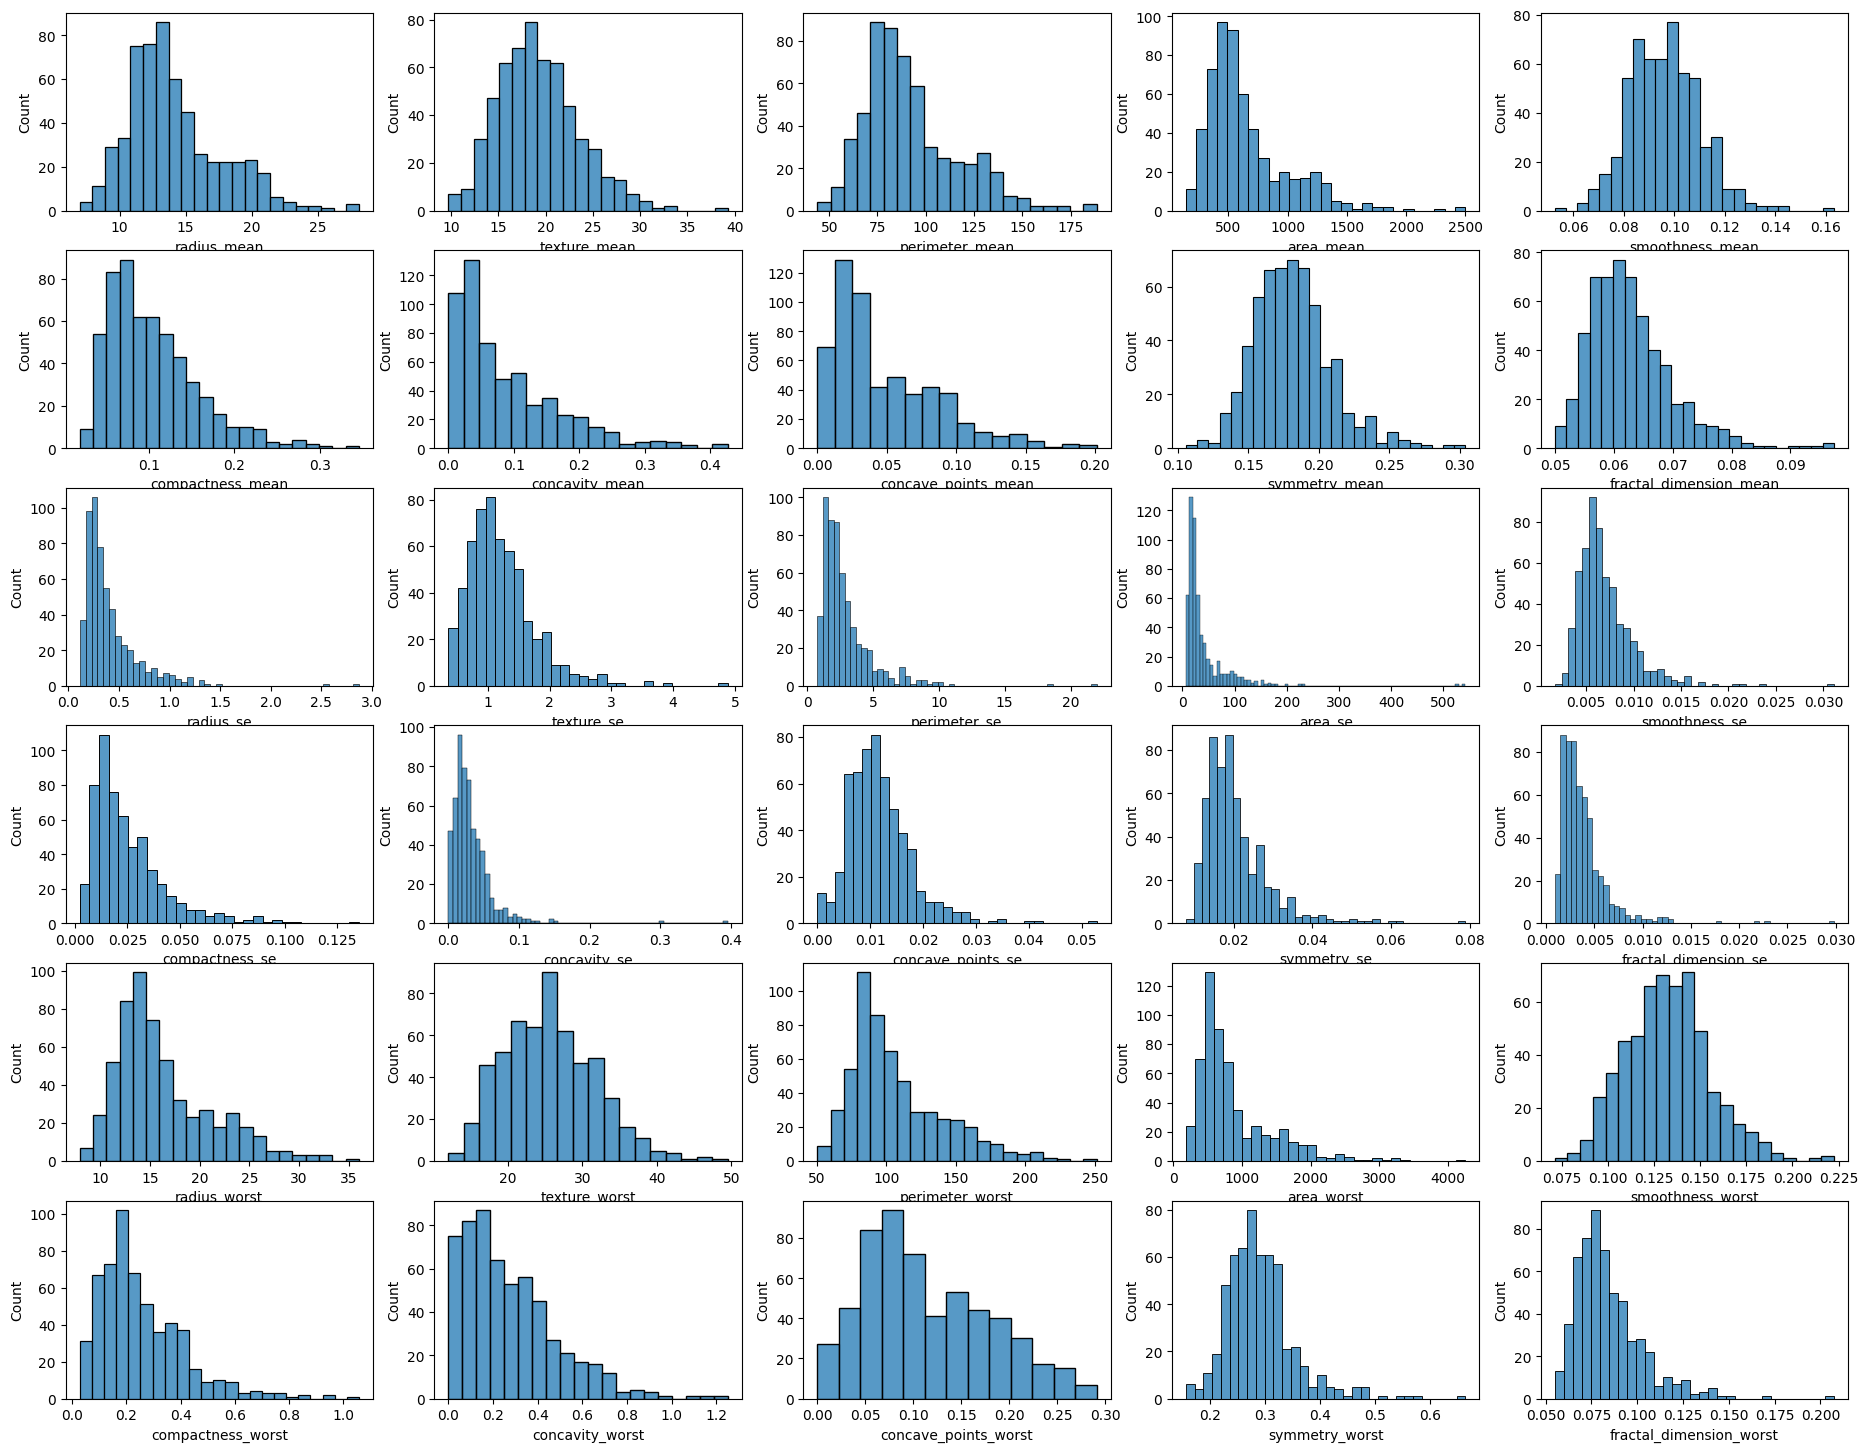

In [ ]:
## And we can quickly visualize these summaries with histograms

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(23, 18))

axes = axes.flatten()

for i, col in enumerate(X.columns):
    sns.histplot(x=X[col], ax=axes[i])

for i in range(len(X.columns), len(axes)):
    fig.delaxes(axes[i])

plt.show()

By inspection of the feature distributions we can see that the features live on very different scales with widely different associated variances. Indeed both logistic regression, neural networks and SVM are rely on the data being scaled. This suggests that an important stage in preprocessing the data would be to scale/normalise the data using the sklearn StandardScaler function. This transforms the data by removing the mean and scaling for unit variance.

It is interesting to note some features (for example symmetry_mean) almost follow a normal distribution whereas others (for example area_mean) seem to follow different distributions (something like a Poisson).

In features such as concavity_se, there appear to be rather large outliers. This could have a detrimental impact on some models, for example models which use a distance metric of mean-squared error (MSE), since these are sensitive to outliers.

It can be useful to check if there are any duplicate data points as these can hold more weight in the model creation than data which has not been duplicated.

In [ ]:
## We can also check if there is any duplicated data
X.duplicated().sum()

0

As we see, there is no issue here.

Let us look at the correlation matrix across all the features combined with the target variable.

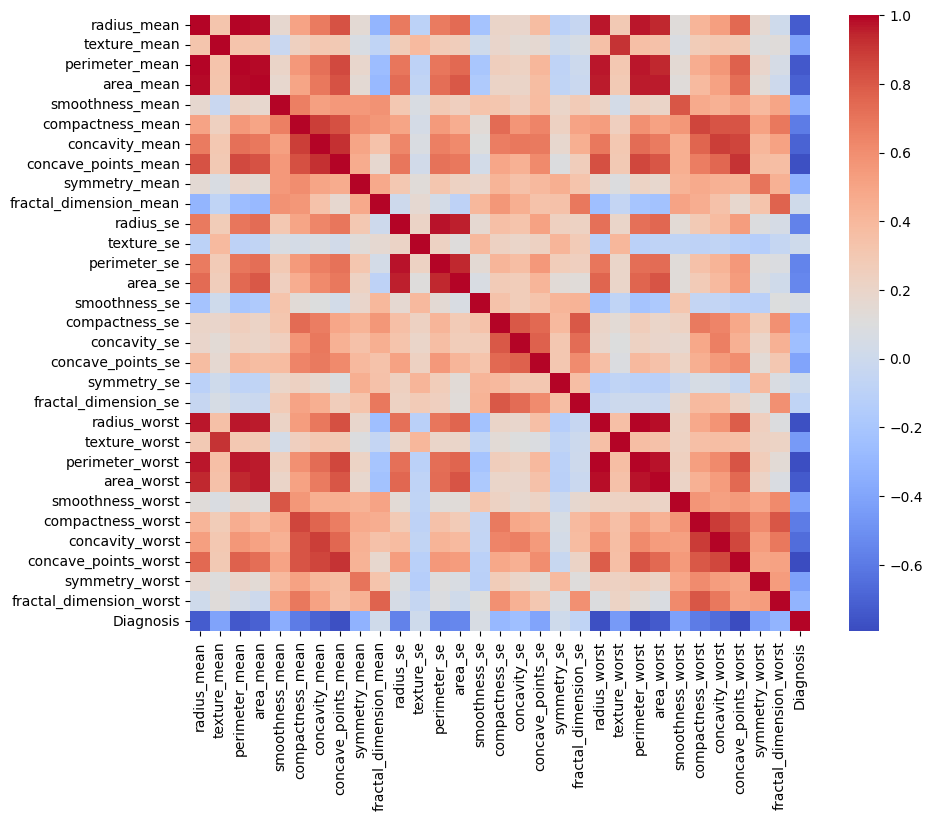

In [ ]:
data = pd.concat([X, y], axis=1)
corr = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', cbar=True)
plt.show()

By looking at the 'Diagnosis' column, we see that nearly all of the input features are somewhat strongly (negatively) correlated to the diagnosis. This is encouraging, as it suggests that the data features will lend themselves well to this classification of diagnosis.

Moreover, we see that a lot of the features are somewhat positively correlated to each other. This is to be expected for a few reasons. Firstly, one would expect that for a given original feature, that their mean, standard error and worst values would be correlated since they are derived from the same sample of features. Secondly, the individual features have been gathered from the same breast tumour cell nuclei, and for example we expect some connection between features like radius, perimeter and area, as they are all measures of the size of these nuclei.


We would like to explore the relationship between two features which are highly correlated: radius_mean and perimeter_mean are almost perfectly correlated with a correlation of 0.997855.

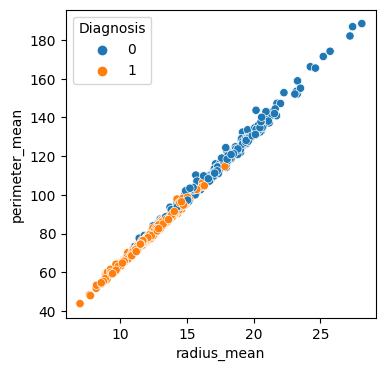

In [ ]:
# Scatter Plot - Attribute radius_mean and Attribute perimeter_mean

plt.figure(figsize=(4,4))
sns.scatterplot(x=X['radius_mean'], y=X['perimeter_mean'], hue=data['Diagnosis'])
plt.show()

As expected, there is an almost perfect correlation between the two features. This of course makes sense as perimeter and radius are close to being scalar multiples of each other (not exactly, however, as the cell nuclei are not necessarily circular as shown in [1]). It also appears as there is a divide between the different diagnoses when the magnitude of the two variables is small or large relatively. This suggests that these variables can hold predictive power.

We repeat this with other variables with varying correlations.

<Figure size 1500x1500 with 0 Axes>

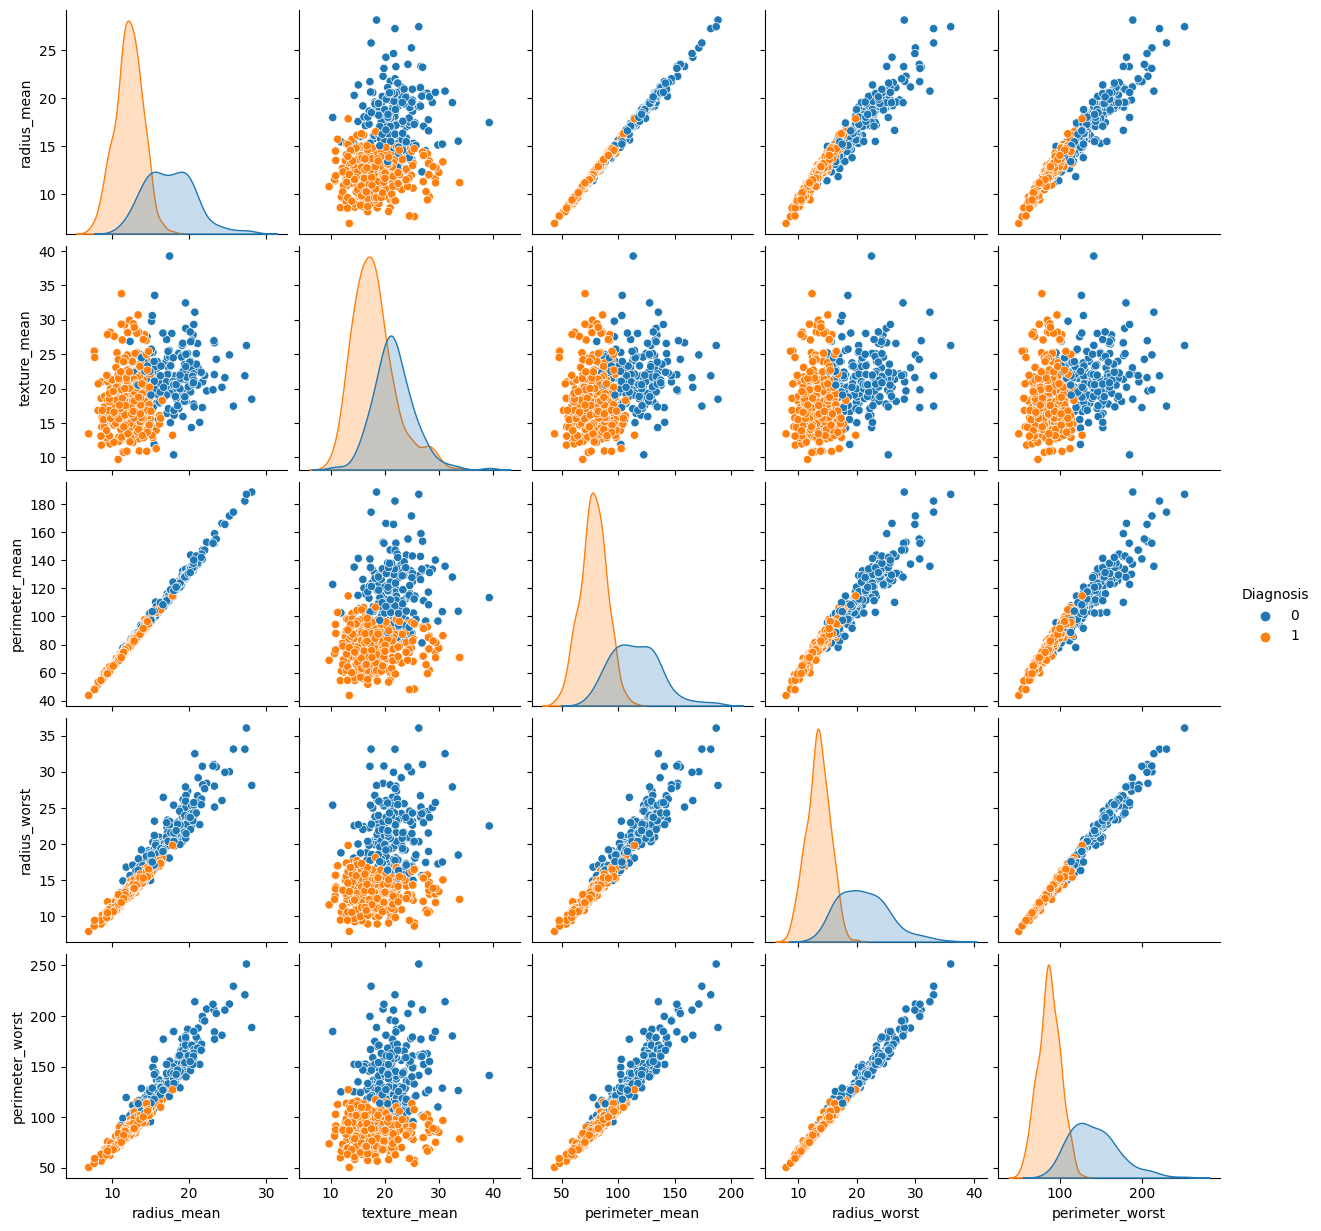

In [ ]:
# pairplot
plt.figure(figsize=(15,15))
sns.pairplot(data, hue="Diagnosis", vars=["radius_mean", "texture_mean", "perimeter_mean", "radius_worst", "perimeter_worst"])
plt.show()

As expected by the correlation matrix, texture_mean is not correlated to the other variables, however there does seem to be a split in diagnoses, suggesting this feature may still hold predictive power.

# Analyse data for colinearity (Andre)

The fact that we have so many high correlation variables make us suspect multicollinearity. Multicollinearity among independent variables will result in less reliable statistical inferences and make it harder to interprate models.

If we look at correlation coefficients below 0.3 we see a lot of features.

In [ ]:
corr = X.corr().iloc[0,][1:]
corr[corr < 0.3]

smoothness_mean            0.170581
symmetry_mean              0.147741
fractal_dimension_mean    -0.311631
texture_se                -0.097317
smoothness_se             -0.222600
compactness_se             0.206000
concavity_se               0.194204
symmetry_se               -0.104321
fractal_dimension_se      -0.042641
texture_worst              0.297008
smoothness_worst           0.119616
symmetry_worst             0.163953
fractal_dimension_worst    0.007066
Name: radius_mean, dtype: float64

We can in theory succesfully predict the target using many predictors with very low correlation. If predictors are not too correlated amongst themselves (avoiding duplication of information). Thus they will tend to add information to the regression even if they are individually adding only a small amount of information. With a sufficient number of (individually) weak predictors you can make a prediction of the response variable that is highly accurate. The overall accuracy is somewhat complicated --- in linear regression it depends on the full correlation matrix of the predictors and their individual correlations with the response variable (see according to https://arxiv.org/abs/2109.08519).

However we can see that least correlation is happening in standard deviation features and lower bound features which won't be sufficient amount of information to get sufficient peditions using "enhancement" phenomena. Hence we will briefly look at variance inflation factor (VIF) which can detect and measure the amount of collinearity to then remove some features.

VIF measures how much the variance of the estimated regression coefficients is inflated as compared to when the predictor variables are not linearly related.

A common heuristic is that a VIF of 1-5 indicates moderate correlation; 5-10 indicates highly correlation.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_calc(df):
  vif = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
  return pd.DataFrame({'Predictors': df.columns, 'VIF': vif})

In [ ]:
vif_calc(df)

,Predictors,VIF
0,radius_mean,63955.019898
1,texture_mean,251.093672
2,perimeter_mean,58213.349861
3,area_mean,1320.282793
4,smoothness_mean,393.418392
5,compactness_mean,200.983909
6,concavity_mean,158.033586
7,concave_points_mean,155.053368
8,symmetry_mean,184.712502
9,fractal_dimension_mean,683.379907


We can see very high numbers on highly correlated values as expected in `perimeter` features with `radius` features. But all the variables show high dependence.

To further improve dataset let's remove certain features to see if that helps us to get more accurate model.

To do this let us first isolate the variables of most interest to us (mean).

In [ ]:
dp = pd.concat([X.iloc[:, :10], y], axis=1)
vif_calc(dp)

,Predictors,VIF
0,radius_mean,27999.328290
1,texture_mean,25.379581
2,perimeter_mean,30133.227621
3,area_mean,158.096502
4,smoothness_mean,136.565757
5,compactness_mean,84.636856
6,concavity_mean,26.088800
7,concave_points_mean,56.366230
8,symmetry_mean,74.980446
9,fractal_dimension_mean,222.695987


Thus we have overall decreased VIF factor, but radius and perimeter are still have large dependence. It is enough to just drop `radius` or `perimeter` to significatly decrease VIF.

In [ ]:
vif_calc(dp.drop(['radius_mean'], axis=1))

,Predictors,VIF
0,texture_mean,25.372693
1,perimeter_mean,373.391395
2,area_mean,150.544876
3,smoothness_mean,134.389136
4,compactness_mean,38.900927
5,concavity_mean,25.017939
6,concave_points_mean,56.063664
7,symmetry_mean,74.677809
8,fractal_dimension_mean,209.513080
9,Diagnosis,7.566210


We can further improve this number by droping `perimeter` as we can see the correlation of `perimeter` with `area` and `fractal_dimension`.

In [ ]:
vif_calc(dp.drop(['radius_mean', 'perimeter_mean'], axis=1))

,Predictors,VIF
0,texture_mean,23.331317
1,area_mean,19.677318
2,smoothness_mean,131.855746
3,compactness_mean,38.710264
4,concavity_mean,24.237530
5,concave_points_mean,55.978502
6,symmetry_mean,71.784016
7,fractal_dimension_mean,190.754709
8,Diagnosis,7.548528


Now let's drop `fractal_dimension`.

In [ ]:
df_mean = dp.drop(['radius_mean', 'perimeter_mean', 'fractal_dimension_mean'], axis=1)
vif_calc(df_mean)

,Predictors,VIF
0,texture_mean,20.733695
1,area_mean,19.585736
2,smoothness_mean,72.110029
3,compactness_mean,34.075592
4,concavity_mean,23.084746
5,concave_points_mean,48.449881
6,symmetry_mean,63.690121
7,Diagnosis,6.509037


In [ ]:
to_drop = ['radius_mean', 'perimeter_mean', 'fractal_dimension_mean', 'radius_se',
           'perimeter_se', 'fractal_dimension_se', 'radius_worst', 'perimeter_worst',
           'fractal_dimension_worst']
df_optim = df.drop(to_drop, axis=1)
vif_calc(df_optim)

,Predictors,VIF
0,texture_mean,232.595725
1,area_mean,75.356947
2,smoothness_mean,319.568462
3,compactness_mean,102.864318
4,concavity_mean,140.680998
5,concave_points_mean,139.475105
6,symmetry_mean,169.843060
7,texture_se,22.852873
8,area_se,8.630869
9,smoothness_se,24.905634


Potentially we could drop these off: `'symmetry_worst', 'smoothness_worst', 'texture_worst', 'concave_points_worst'`.

# Data preparation

We split the data into a train and test set, fixing the random_state to ensure reproducibility.

In [ ]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

Checking that the X_train and y_train match up.

In [ ]:
X_train.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
342,11.06,14.96,71.49,373.9,0.10330,0.09097,0.05397,0.03341,0.1776,0.06907,...,11.92,19.90,79.76,440.0,0.1418,0.2210,0.2299,0.10750,0.3301,0.09080
138,14.95,17.57,96.85,678.1,0.11670,0.13050,0.15390,0.08624,0.1957,0.06216,...,18.55,21.43,121.40,971.4,0.1411,0.2164,0.3355,0.16670,0.3414,0.07147
434,14.86,16.94,94.89,673.7,0.08924,0.07074,0.03346,0.02877,0.1573,0.05703,...,16.31,20.54,102.30,777.5,0.1218,0.1550,0.1220,0.07971,0.2525,0.06827
47,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,...,15.67,27.95,102.80,759.4,0.1786,0.4166,0.5006,0.20880,0.3900,0.11790
64,12.68,23.84,82.69,499.0,0.11220,0.12620,0.11280,0.06873,0.1905,0.06590,...,17.09,33.47,111.80,888.3,0.1851,0.4061,0.4024,0.17160,0.3383,0.10310


In [ ]:
y_train.head()

,Diagnosis
342,1
138,0
434,1
47,0
64,0


Then, as discussed, we rescale the data to be normalised.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Useful functions

We define some functions that will be useful for the rest of our experiments.

In [ ]:
def calculations(y_test, pred_svc):
    [[TN, FP] , [FN, TP]] = confusion_matrix(y_test, pred_svc).tolist()
    P = TP + FN
    N = TN + FP
    return P, N, TN, FP, FN, TP

def metric_sensitivity(y_test, pred_svc):
    [P,_,_,_,_,TP] = calculations(y_test, pred_svc)
    return TP / P

def metric_specificity(y_test, pred_svc):
    [_,N,TN,_,_,_] = calculations(y_test, pred_svc)
    return TN / N

def metric_accuracy(y_test, pred_svc):
    [P,N,TN,_,_,TP] = calculations(y_test, pred_svc)
    return (TP + TN) / (P + N)

def performance(confusion_matrix):
    [[TN, FP] , [FN, TP]] = confusion_matrix.tolist()
    P = TP + FN
    N = TN + FP
    sens = TP / P
    spec = TN / N
    acc = (TP + TN) / (P + N)
    print(f"Accuracy = {acc}")
    print(f"Sensitivity = {sens}")
    print(f"Specificity = {spec}")
    return

def calculate_sensitivity(y_true, y_pred):
    true_positive = ((y_pred == 1) & (y_true == 1)).sum().item()
    actual_positive = (y_true == 1).sum().item()
    sensitivity = true_positive / actual_positive if actual_positive > 0 else 0
    return sensitivity

We also define the following function that will set seeds across multiple Python packages used to ensure reproducibility. We will call this appropriately in all of our experiments.

In [ ]:
def fix_seed():
  # Set seeds for reproducibility
  seed_value = 42

  # 1. Set the seed for Python's built-in random number generator
  random.seed(seed_value)

  # 2. Set the seed for NumPy
  np.random.seed(seed_value)

  # 3. Set the seed for PyTorch
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)  # if using multiple GPUs
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# SVM (Andre)

A Support Vector Machine (SVM) determines the optimal hyperplane to divide classes. It is achieved by maximising the gap between the decision boundary and each class of points. For the linear classifier of our two class data, we can have infinitely many decision boundaries between classes.

This algorithm is very efficient as instead of looking at all the data points, SVM focuses on just a few key ones known as support vectors, which are the data points closest to the dividing line. These support vectors guide SVM in choosing the best possible dividing line.

To achieve this, we use a cost function. This function represents the gap between the data points and the dividing line. We strive to maximize this gap, which means we aim to minimize something called hinge loss. Hinge loss measures how far a point is from the dividing line when it's wrongly classified.

For our dataset of sample size 569 with 31 numeric predictors without encoding, Support Vector Machine (SVM) is a fitting model because:
1. SVM is more effective in high-dimensional spaces;
2. SVM are less likely to overfit to training data as less sensitive to outliers than logistic regression;
2. SVM is less sensitive to multicollinearity. In particular, we will consider non-linear SVMs.:

As well as all of the disadvantages are avoided:
1. The dataset is not large;
2. The number of features for each data point doesn't exceed the number of training data samples ie SVM won't underperform;
3. The data set is not too noisy and target classes are not overlapping.

In [ ]:
from sklearn.svm import SVC, LinearSVC

There are two different implementations of linear SVC `LinearSVC` and `SVC(kernel='linear')` which differ based on implementation (ie liblinear and libsvm respectively).

"The main differences between LinearSVC and SVC lie in the loss function used by default, and in the handling of intercept regularization between those two implementations." from the documentation.

Hence a minimal test was performed to compare these to different implementations for linear SVC.

In [ ]:
lin_svc = LinearSVC()
grid_svc = GridSearchCV(lin_svc, {'C':[1, .1, .01, .001]}, cv=10) # GridSearchCV rely on an internal scoring strategy
grid_svc.fit(X_train_scaled, y_train.values.ravel())
print("Best C:", grid_svc.best_params_)
print("Best train score:", grid_svc.best_score_)
print("Best test score:", grid_svc.best_estimator_.score(X_test_scaled, y_test))

Best C: {'C': 0.01}
Best train score: 0.9801932367149758
Best test score: 0.9912280701754386


The hyperparameter C in SVM controls the trade-off between the training error and the margin since it can determine the penalty for misclassified data points during the training process.

A smaller value of C allows for a larger margin (possibly more misclassification on the training data). While a larger C minimises the training error (possibly leads to a narrower margin).

Hence we need to optimise for the best C parameter. We will also consider different kernels in the process.

For the high amount of features, we expect linear kernel to produce more useful results. While the RBF (Radial Basis Function) kernel has the advantages of KNN and overcomes the space complexity problem. Just like linear kernel, polynomial kernel is effective for high-dimensional datasets with a relatively small number of training samples as well as can capture non-linear relationships.

In [ ]:
params_svc = {
    'C': [1, .1, .01, .001],
    'kernel': ['linear', 'poly', 'rbf']
}

Implementing metrics we agreed upon:

In [ ]:
from sklearn.metrics import make_scorer
scoring = {
    "accuracy": make_scorer(metric_accuracy),
    "specificity": make_scorer(metric_specificity),
    "sensitivity": make_scorer(metric_sensitivity),
    "roc": 'roc_auc'
}

linearSVC_test = [0, 0, 0]
linearSVC_train = [0, 0, 0]

In [ ]:
# demonstrating basic apporach with accuracy
fix_seed()
grid_svc = GridSearchCV(LinearSVC(), {'C':[1, .1, .01, .001]}, cv=5, scoring=scoring['accuracy'], return_train_score=True)
grid_svc.fit(X_train_scaled, y_train.values.ravel())
print("Best C:", grid_svc.best_params_)
print("Best train score:", grid_svc.best_score_)
clf = grid_svc.best_estimator_
linearSVC_train[0] = grid_svc.best_score_
linearSVC_test[0] = metric_accuracy(y_test, clf.predict(X_test_scaled))
print("Train score:", clf.score(X_train_scaled, y_train))
print("Test score:", linearSVC_test[0])

Best C: {'C': 0.01}
Best train score: 0.9802197802197803
Train score: 0.9868131868131869
Test score: 0.9912280701754386


In [ ]:
# demonstrating basic apporach with specificity
fix_seed()
grid_svc = GridSearchCV(LinearSVC(), {'C':[1, .1, .01, .001]}, cv=5, scoring=scoring['specificity'], return_train_score=True)
grid_svc.fit(X_train_scaled, y_train.values.ravel())
print("Best C:", grid_svc.best_params_)
print("Best train score:", grid_svc.best_score_)
clf = grid_svc.best_estimator_
linearSVC_train[1] = grid_svc.best_score_
linearSVC_test[1] = metric_specificity(y_test, clf.predict(X_test_scaled))
print("Train score:", metric_specificity(y_train, clf.predict(X_train_scaled)))
print("Test score:", linearSVC_test[1])

Best C: {'C': 0.1}
Best train score: 0.9552380952380952
Train score: 0.9719101123595506
Test score: 1.0


In [ ]:
# demonstrating basic apporach with sensitivity
fix_seed()
grid_svc = GridSearchCV(LinearSVC(), {'C':[1, .1, .01, .001]}, cv=5, scoring=scoring['sensitivity'], return_train_score=True)
grid_svc.fit(X_train_scaled, y_train.values.ravel())
print("Best C:", grid_svc.best_params_)
print("Best train score:", grid_svc.best_score_)
clf = grid_svc.best_estimator_
linearSVC_train[2] = grid_svc.best_score_
linearSVC_test[2] = metric_sensitivity(y_test, clf.predict(X_test_scaled))
print("Train score:", metric_sensitivity(y_train, clf.predict(X_train_scaled)))
print("Test score:", linearSVC_test[2])

Best C: {'C': 0.01}
Best train score: 0.9964285714285716
Train score: 0.9963898916967509
Test score: 0.9875


Overall it is interesting to see that a standard linear SVC performs exceptionally well on the data with minimal optimisation and without overfitting.

Since SVMs are prone to shift, I believe all the measures are worth the consideration, but the score of 98.75% on sensitivity is the best performance of the model we will get.

Now to make this into an abstract approach and show all the values we consider in gridsearchcv:

In [ ]:
metric_order = ['Accuracy', 'Specificity', 'Sensitivity', 'ROC']

In [ ]:
def gridSearch(scoring, X_train_scaled):
  fix_seed()
  grid_svc = GridSearchCV(SVC(), params_svc, scoring=scoring, cv=15)
  grid_svc.fit(X_train_scaled, y_train.values.ravel())
  print(f'Model of {scoring}')
  print("Best C:", grid_svc.best_params_)
  print("Best train score:", grid_svc.best_score_)
  cv_results = grid_svc.cv_results_

  scores_mean = np.array(cv_results['mean_test_score']).reshape(len(params_svc['kernel']),len(params_svc['C']))
  scores_sd = np.array(cv_results['std_test_score']).reshape(len(params_svc['kernel']),len(params_svc['C']))

  # Plot Grid search scores
  _, ax = plt.subplots(1,1)

  xaxis = np.log(params_svc['C']) # scale x-axis

  # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
  for idx, val in enumerate(params_svc['kernel']):
      ax.plot(xaxis, scores_mean[idx,:], '-o', label= f'kernel {val}')

  plt.xticks(xaxis, params_svc['C'])
  ax.set_title(f"Grid Search Scores")
  ax.legend()
  plt.xlabel('Hyperparameter C')
  plt.ylabel(f'Score ({scoring})')
  ax.grid('on')
  plt.show()
  return grid_svc

Model of accuracy
Best C: {'C': 0.1, 'kernel': 'linear'}
Best train score: 0.9801433691756273


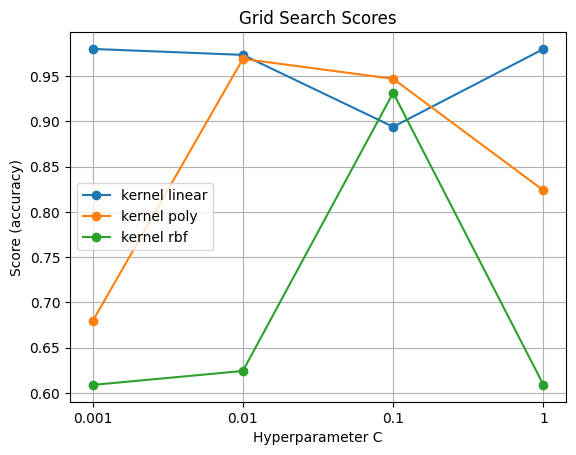

Model of make_scorer(matric_sensitivity)
Best C: {'C': 1, 'kernel': 'poly'}
Best train score: 1.0


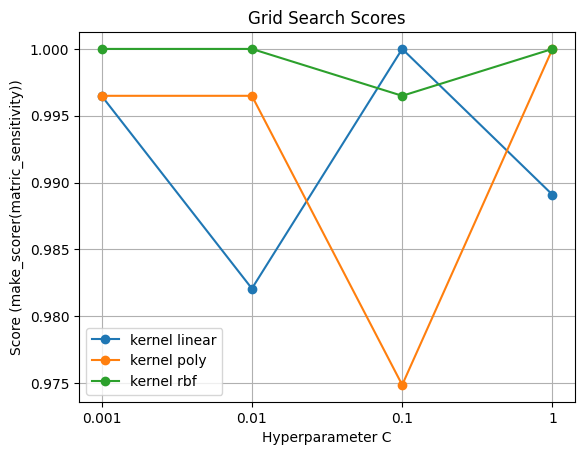

Model of make_scorer(matric_specificity)
Best C: {'C': 1, 'kernel': 'linear'}
Best train score: 0.9661616161616161


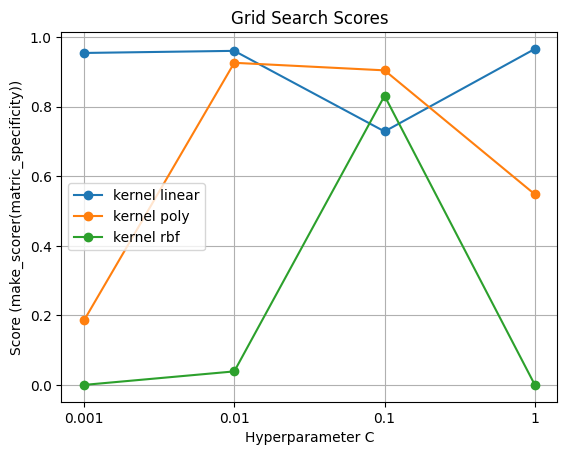

Model of roc_auc
Best C: {'C': 1, 'kernel': 'linear'}
Best train score: 0.9975308641975308


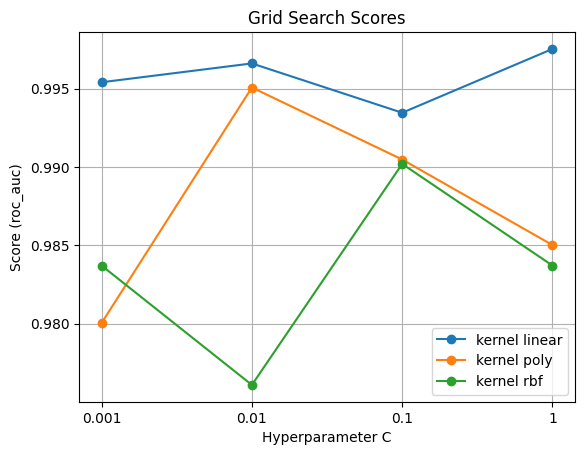

In [ ]:
grid_svc_acc = gridSearch('accuracy', X_train_scaled)
grid_svc_sens = gridSearch(scoring['sensitivity'], X_train_scaled)
grid_svc_spec = gridSearch(scoring['specificity'], X_train_scaled)
grid_svc_roc = gridSearch('roc_auc', X_train_scaled)

In [ ]:
modelsCV = [grid_svc_acc, grid_svc_spec, grid_svc_sens, grid_svc_roc]

Values in above graph is hard to interprate hence we will use different visualisation. The idea is to consider all the metric over specific kernel

In [ ]:
def gridSearchV2(kernel):
  fix_seed()
  for metric in metric_order:
    grid_svc = GridSearchCV(SVC(kernel=kernel), {'C': [1, .1, .01, .001]}, scoring=scoring[metric.lower()], cv=10)
    grid_svc.fit(X_train_scaled, y_train.values.ravel())
    cv_results = grid_svc.cv_results_

    scores_mean = np.array(cv_results['mean_test_score'])

    # Plot Grid search scores

    xaxis = np.log(params_svc['C']) # scale x-axis

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    plt.plot(xaxis, scores_mean, '-o', label=f'metric {metric}')

  plt.xticks(xaxis, params_svc['C'])
  plt.title(f"Grid Search Scores for kernel={kernel}")
  plt.legend()
  plt.xlabel('Hyperparameter C')
  plt.ylabel(f'Score')
  plt.grid('on')
  plt.show()

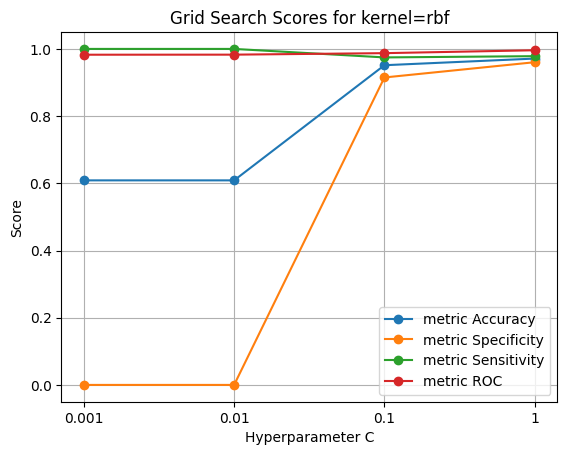

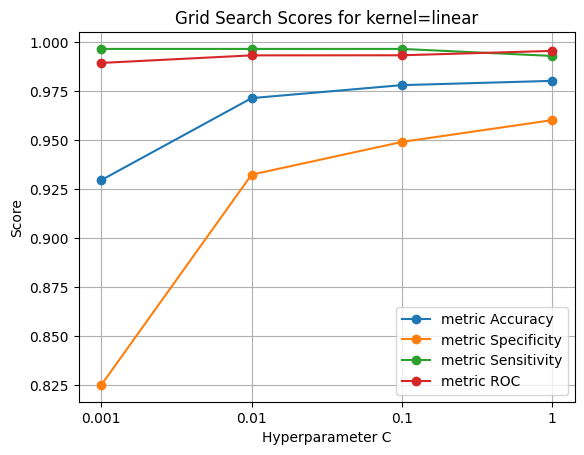

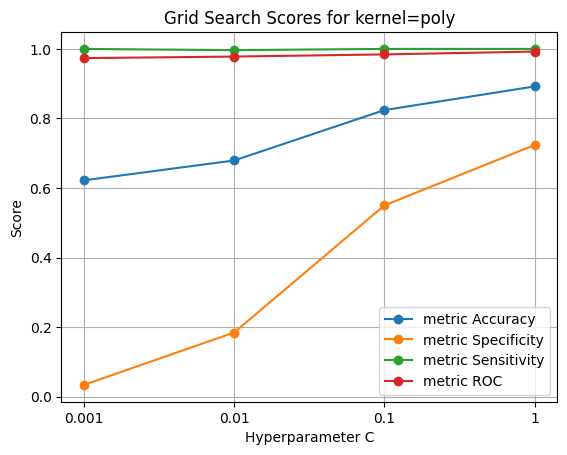

In [ ]:
for kernel in ['rbf', 'linear', 'poly']:
  gridSearchV2(kernel)

It's fine to use ROC since the target has balanced classes.

It is worth noting that the linear kernel model has performed overall the best.

We have noticed that we have Sensitivity and ROC metric are performing the best on each value which is odd result and is indicative of the nature of the SVM.

This allows us to conclude that the data we want to consider is accuracy and specificity with SVCs in our GridSearchCV optimisation.

It's also interesting that RBF kernel seems to optimise all the metric at C=1 while it doesn't produce the best score it produces the best score overall.

Checking scores of train vs test for our 'best outliers':

In [ ]:
metrics = [metric_accuracy, metric_specificity, metric_sensitivity, roc_auc_score]
test_scores_all = [metric(y_test, model.best_estimator_.predict(X_test_scaled)) for model, metric in zip(modelsCV, metrics)]
svm_scores = pd.DataFrame({
    'Model': [x.best_estimator_ for x in modelsCV],
    'Train Score': [metric(y_train, model.best_estimator_.predict(X_train_scaled)) for model, metric in zip(modelsCV, metrics)],
    'Test Score': test_scores_all
    }, index=metric_order)
svm_scores

,Model,Train Score,Test Score
Accuracy,"SVC(C=0.1, kernel='linear')",0.986813,0.973684
Specificity,"SVC(C=1, kernel='linear')",0.977528,1.000000
Sensitivity,"SVC(C=1, kernel='poly')",1.000000,1.000000
ROC,"SVC(C=1, kernel='linear')",0.986959,0.956250


These results are hard to inteprate since they need to be done in the graph comparison. But tells that we can get best values for most metrics with linear kernel.

If we look in more details on the graph of sensetivity that a lot of kernels preform well on them.

Let's also explore data for data with pruned features.

In [ ]:
X_optim = df_optim.loc[:, df_optim.columns != 'Diagnosis']
y_optim = df_optim['Diagnosis']
X_optim_train, X_optim_test, y_optim_train, y_optim_test = train_test_split(X_optim, y_optim, test_size=0.2, random_state=4)
scaler_optim = StandardScaler()
X_optim_train_scaled = scaler_optim.fit_transform(X_optim_train)
X_optim_test_scaled = scaler_optim.transform(X_optim_test)

Model of accuracy
Best C: {'C': 1, 'kernel': 'linear'}
Best train score: 0.9735483870967742


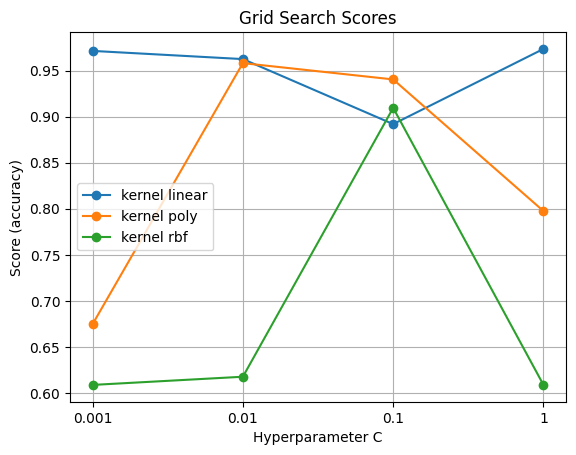

Model of make_scorer(matric_sensitivity)
Best C: {'C': 0.1, 'kernel': 'poly'}
Best train score: 1.0


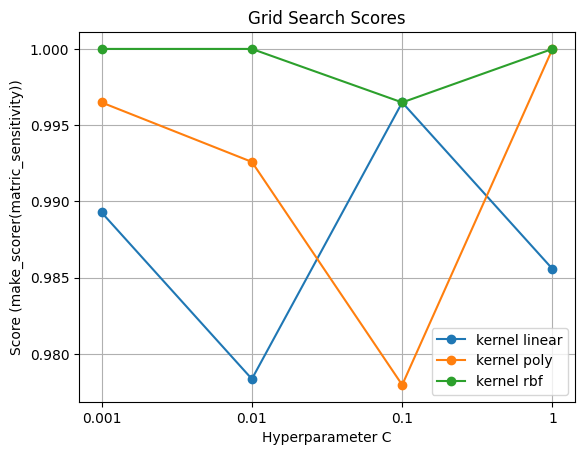

Model of make_scorer(matric_specificity)
Best C: {'C': 1, 'kernel': 'linear'}
Best train score: 0.9545454545454545


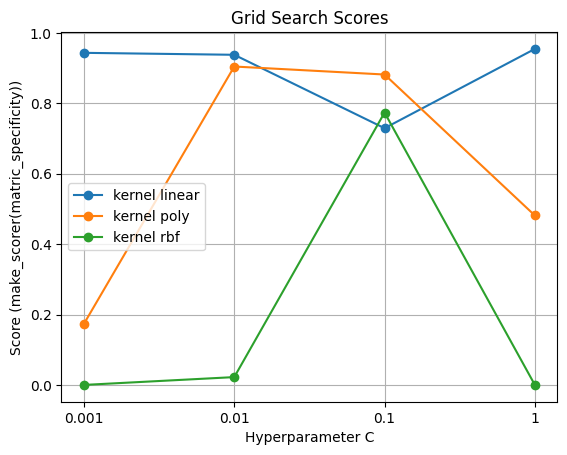

Model of roc_auc
Best C: {'C': 1, 'kernel': 'linear'}
Best train score: 0.9957764782326186


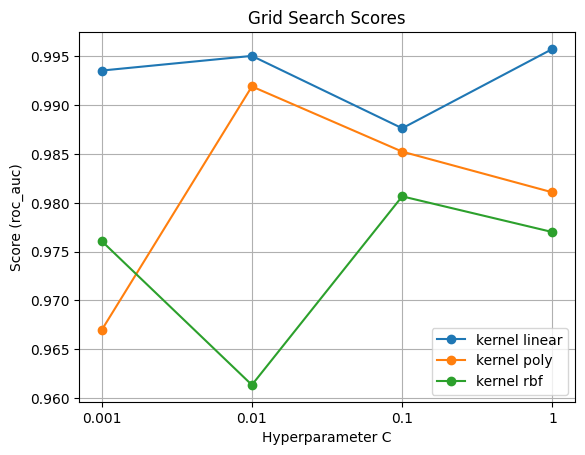

In [ ]:
modelsCV_17 = []
modelsCV_17 += [gridSearch('accuracy', X_optim_train_scaled)]
modelsCV_17 += [gridSearch(scoring['sensitivity'], X_optim_train_scaled)]
modelsCV_17 += [gridSearch(scoring['specificity'], X_optim_train_scaled)]
modelsCV_17 += [gridSearch('roc_auc', X_optim_train_scaled)]

The only changes that happened are on sensetivity and ROC metrics.
Where over ROC all kernels performed worse and over sensitivity metric we have worse results for linear kernel and better results for polynomial metric.
Results are inconclusive but overall there seems no benefit in pruning the features the way it was done in the analysis of VIF coefficients.

In [ ]:
test_scores_17 = [metric(y_optim_test, model.best_estimator_.predict(X_optim_test_scaled)) for model, metric in zip(modelsCV_17, metrics)]
svm_scores_17 = pd.DataFrame({
    'Model': [x.best_estimator_ for x in modelsCV_17],
    'Train Score': [x.best_score_ for x in modelsCV_17],
    'Test Score': test_scores_17
    }, index=metric_order)
svm_scores_17

,Model,Train Score,Test Score
Accuracy,"SVC(C=1, kernel='linear')",0.973548,0.973684
Specificity,"SVC(C=0.1, kernel='poly')",1.000000,0.617647
Sensitivity,"SVC(C=1, kernel='linear')",0.954545,0.962500
ROC,"SVC(C=1, kernel='linear')",0.995776,0.981250


For conclusion below are all the results:

In [ ]:
pd.DataFrame({
    'Model': [f'{x.best_estimator_} 17 features' for x in modelsCV_17] + [f'{x.best_estimator_} all features' for x in modelsCV] + ['linearSVC all features'] * 3,
    'Best Train Score': [x.best_score_ for x in modelsCV_17 + modelsCV] + linearSVC_train,
    'Test Score': test_scores_17 + test_scores_all + linearSVC_test
    }, index=metric_order+metric_order+metric_order[:3])

,Model,Best Train Score,Test Score
Accuracy,"SVC(C=1, kernel='linear') 17 features",0.973548,0.973684
Specificity,"SVC(C=0.1, kernel='poly') 17 features",1.000000,0.617647
Sensitivity,"SVC(C=1, kernel='linear') 17 features",0.954545,0.962500
ROC,"SVC(C=1, kernel='linear') 17 features",0.995776,0.981250
Accuracy,"SVC(C=0.1, kernel='linear') all features",0.980143,0.973684
Specificity,"SVC(C=1, kernel='linear') all features",0.966162,1.000000
Sensitivity,"SVC(C=1, kernel='poly') all features",1.000000,1.000000
ROC,"SVC(C=1, kernel='linear') all features",0.997531,0.956250
Accuracy,linearSVC all features,0.980220,0.991228
Specificity,linearSVC all features,0.955238,1.000000


We have most of our predictors highly correlated with each other and a quarter of them have a high correlation of >0.6. This is expected for instance radius is perfectly correlated with pretimiter as expected. Thus we expected to get improvement from the feature pruning defined in the analysis of colinearity but didn't get any significant improvements on our model. Perhaps further conclusions have to be drawn from logistic regression with lasso coefficients.

As was earlier mentioned it's hard to interpret the model due to multicollinearity but we can say that a linear SVM is a good fit for the data across all relevant metrics with exceptional performance above 95%.

An interesting point is also that `SVM` performed worse with the linear kernel as opposed to `linearSVM`. The best model is indeed the `linearSVM` model with C=0.01 based on both accuracy and sensitivity. However, there is a potential for an overfitted model as it performed worse on the test set in sensitivity.

One of the interesting points is that we considered which kernels excelled for each metric and for what values.

# Logistic Regression (Geraint)

Logistic regression is a supervised machine learning algorithm, used to estimate the parameters of the logistic model. To do this we use the log-likelihood function, with an optional regularisation term, and then find values of the parameters that maximise this function using numerical optimisation techniques. We will investigate the effectiveness of different regularisation techniques as well as dropping specified features from the previous VIF analysis.

In [ ]:
#We create a logistic model with no regularisation, therefore must use 'lbfgs' solver
model0 = LogisticRegression(penalty='none', solver='lbfgs')

In [ ]:
#We fit the model with our training data, requires target feature to be changed to a 1d array
y_train0 = np.ravel(y_train)
model0.fit(X_train_scaled,y_train0)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(penalty='none')

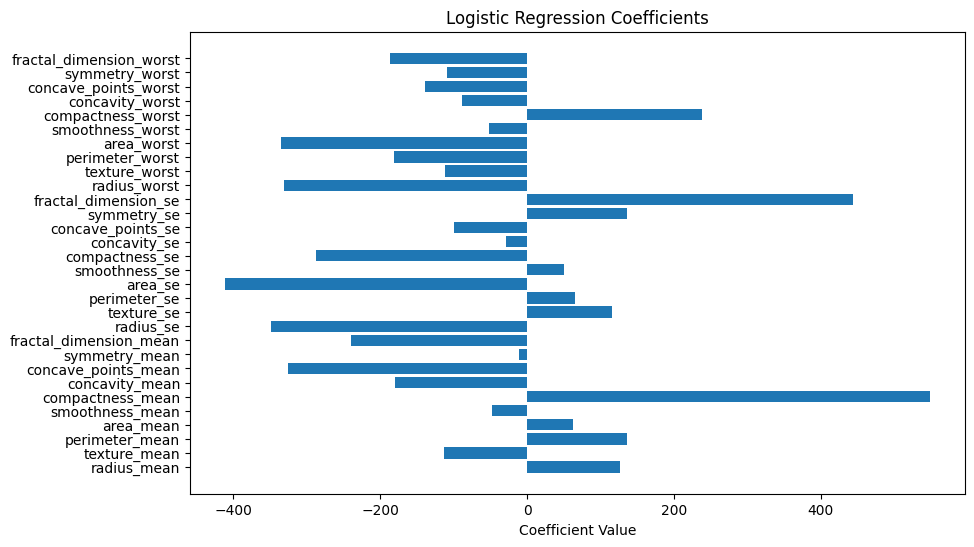

In [ ]:
#we can inspect the coefficients of the model and visualise them
coef0 = model0.coef_[0]
feature_names = X.columns.tolist()
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coef0)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()

In [ ]:
#make predictions
predictions0 = model0.predict(X_test_scaled)

In [ ]:
#compare predictions with observed data using a confusion matrix
cm0 = confusion_matrix(y_test, predictions0)
print(cm0)

[[34  0]
 [ 6 74]]


In [ ]:
#now use the performance function to obtain the 3 main performance metrics
performance(cm0)

Accuracy = 0.9473684210526315
Sensitivity = 0.925
Specificity = 1.0


As expected we see a fairly poor performance, especially in terms of sensitivity, the metric we are aiming to optimise for. From our analysis of the correlations, we see that there is high multicolinearity in the data, this breaks an assumption in the logistic model. We can run logistic regression only looking at selected features from that section that reduce the VIF and see whether this improves performance.

In [ ]:
to_drop = ['radius_mean', 'perimeter_mean', 'fractal_dimension_mean', 'radius_se',
           'perimeter_se', 'fractal_dimension_se', 'radius_worst', 'perimeter_worst',
           'fractal_dimension_worst']
X_opt = X.drop(to_drop , axis = 1)
X_train1, X_test1, y_train, y_test = train_test_split(X_opt, y, test_size=0.2, random_state=4)
scaler = StandardScaler()
X_train_scaled1 = scaler.fit_transform(X_train1)
X_test_scaled1 = scaler.transform(X_test1)

In [ ]:
model1 = LogisticRegression(penalty='none', solver='lbfgs')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


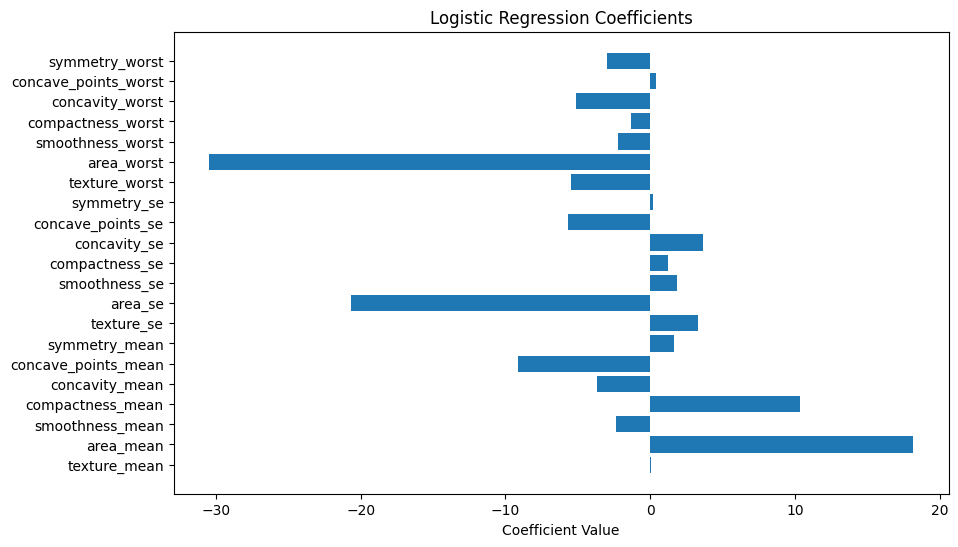

In [ ]:
model1.fit(X_train_scaled1, y_train0)
coef1 = model1.coef_[0]
feature_names_opt = X.columns.drop(to_drop)
plt.figure(figsize=(10, 6))
plt.barh(feature_names_opt, coef1)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()

In [ ]:
predictions1 = model1.predict(X_test_scaled1)

In [ ]:
cm1 = confusion_matrix(y_test, predictions1)
print(cm1)

[[34  0]
 [ 6 74]]


In [ ]:
performance(cm1)

Accuracy = 0.9473684210526315
Sensitivity = 0.925
Specificity = 1.0


Interestingly, we obtain the exact same performance. As our dataset is small, we have a high granularity in the possible performances so this is just a coincidence, the code below confirms this. Therefore we see that dropping features in an attempt to reduce multicolinearity does not improve performance.


In [ ]:
predictions0 == predictions1

array([ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

This shows that although we have the exact same performance, the predictions do not match exactly.

Now we look at regularisation, this adds a penalty term to the log-odds function and controls the complexity of the model to reduce overfitting. We will begin with L2 or 'ridge' regularisation which adds the square of the coefficients, multiplied by a constant called the L2 factor, to the loss function. The factor varies the strength of the regularisation and we will use the default L2 factor for now which is 1.


In [ ]:
model2 = LogisticRegression(penalty= 'l2' , solver='lbfgs')
model2.fit(X_train_scaled, y_train0)

LogisticRegression()

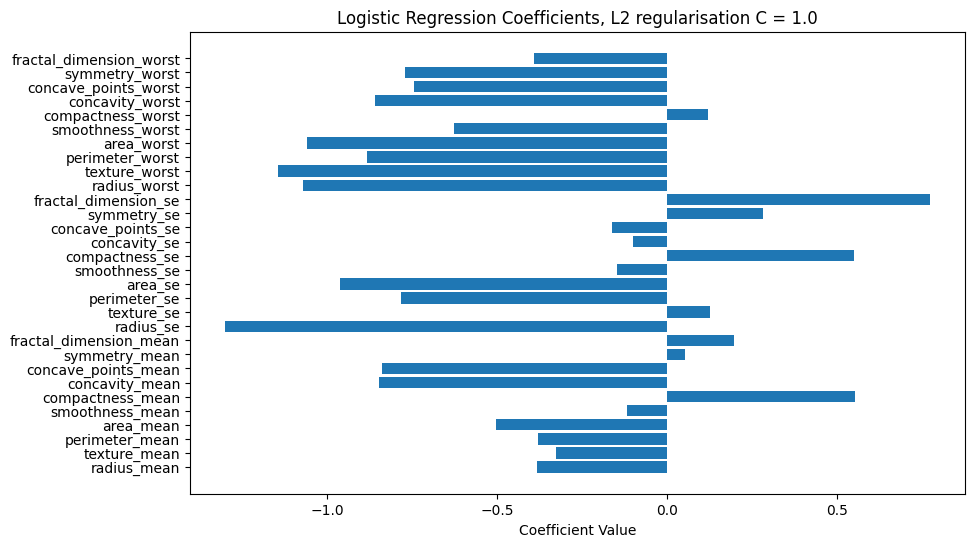

In [ ]:
coef2 = model2.coef_[0]
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coef2)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients, L2 regularisation C = 1.0')
plt.show()

In [ ]:
predictions2 = model2.predict(X_test_scaled)

In [ ]:
cm2 = confusion_matrix(y_test, predictions2)
print(cm2)

[[34  0]
 [ 4 76]]


In [ ]:
performance(cm2)

Accuracy = 0.9649122807017544
Sensitivity = 0.95
Specificity = 1.0


We have improved on the previous models in all performance metrics. Now we can investigate whether larger or smaller values of the L2 coefficient improve our performance further. In sklearn logistic regression, to set the L2 factor, we set C which is the inverse of the factor.

In [ ]:
model3 = LogisticRegression(penalty= 'l2' , solver='liblinear' , C= 0.5)
model3.fit(X_train_scaled, y_train0)

LogisticRegression(C=0.5, solver='liblinear')

In [ ]:
model4 = LogisticRegression(penalty= 'l2' , solver='liblinear' , C= 1.5)
model4.fit(X_train_scaled, y_train0)

LogisticRegression(C=1.5, solver='liblinear')

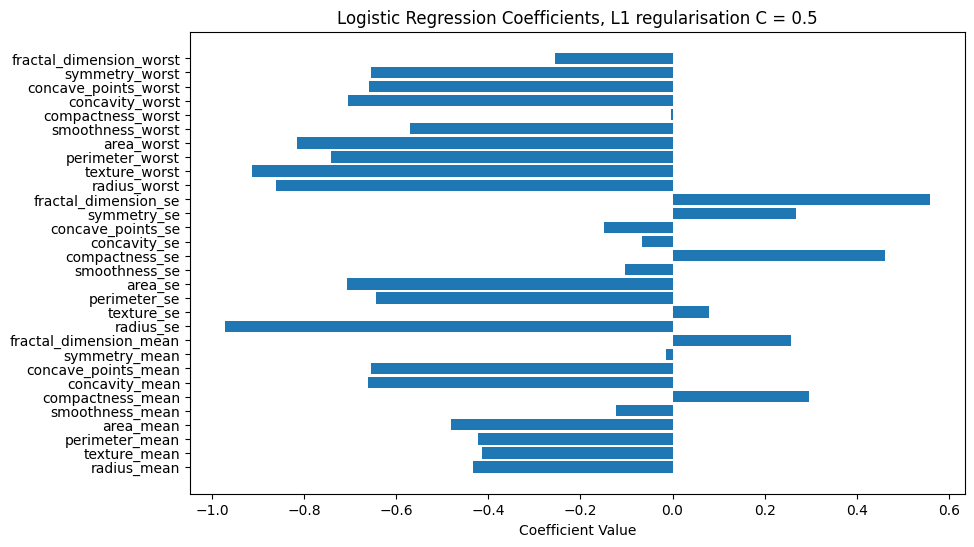

In [ ]:
coef3 = model3.coef_[0]
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coef3)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients, L1 regularisation C = 0.5')
plt.show()

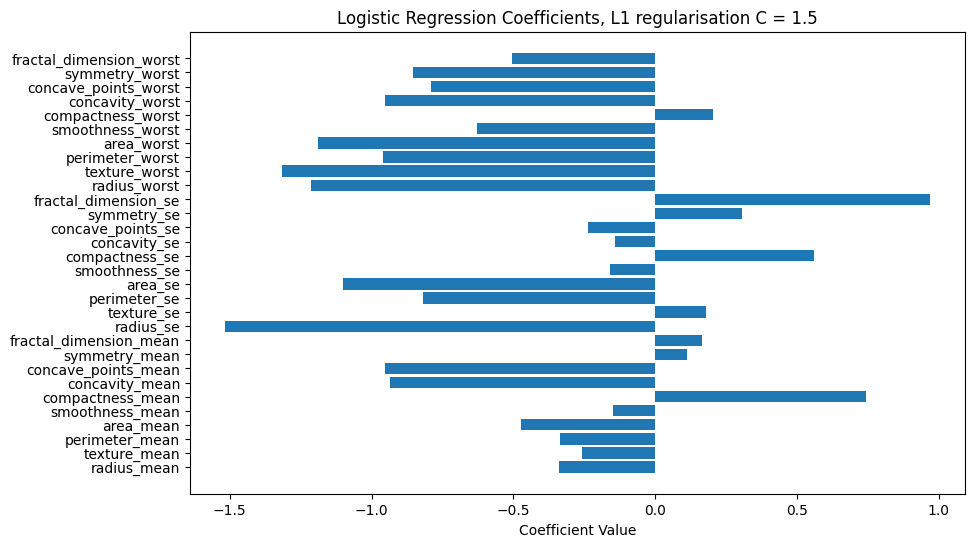

In [ ]:
coef4 = model4.coef_[0]
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coef4)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients, L1 regularisation C = 1.5')
plt.show()

In [ ]:
predictions3 = model3.predict(X_test_scaled)

In [ ]:
predictions4 = model4.predict(X_test_scaled)

In [ ]:
cm3 = confusion_matrix(y_test, predictions3)
print(cm3)

[[34  0]
 [ 4 76]]


In [ ]:
cm4 = confusion_matrix(y_test, predictions4)
print(cm4)

[[34  0]
 [ 5 75]]


In [ ]:
performance(cm3)

Accuracy = 0.9649122807017544
Sensitivity = 0.95
Specificity = 1.0


In [ ]:
performance(cm4)

Accuracy = 0.956140350877193
Sensitivity = 0.9375
Specificity = 1.0


We see the same performance for C = 0.5 and worse for C = 1.5, so we see no improvement when changing the L2 factor from its default.

Now we can see whether L1 or lasso regularisation can improve further. L1 regularisation adds the absolute values of the coefficients to the loss function, multiplied by the L1 factor. This has a greater effect on the coefficients and can reduce some down to 0, which could help to further reduce colinearity. Again we start with the default L1 factor, 1.

In [ ]:
#use liblinear solver as this is compatible with L1 regularisation
model5 = LogisticRegression(penalty= 'l1' , solver='liblinear')
model5.fit(X_train_scaled, y_train0)

LogisticRegression(penalty='l1', solver='liblinear')

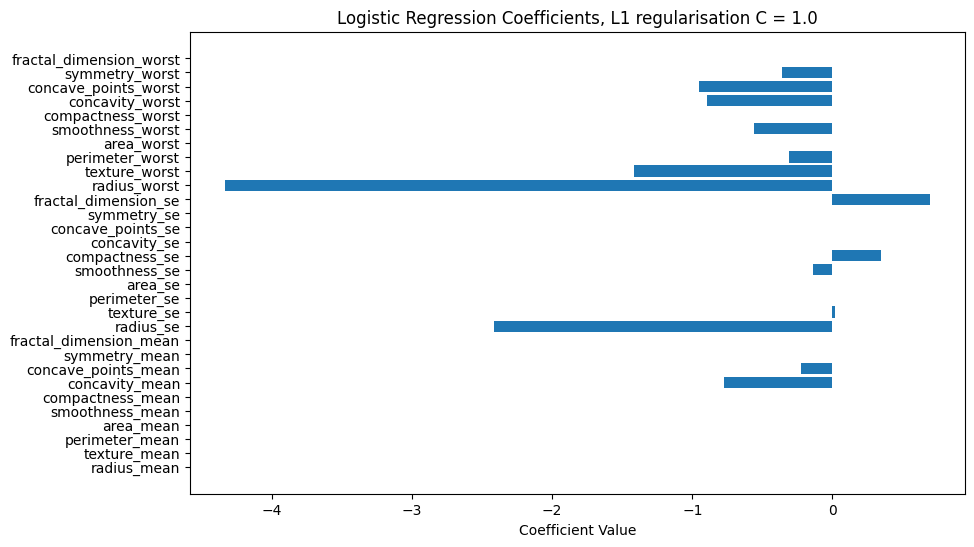

In [ ]:
coef5 = model5.coef_[0]
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coef5)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients, L1 regularisation C = 1.0')
plt.show()

We see that the L1 regularisation has driven many of coefficients to zero

In [ ]:
predictions5 = model5.predict(X_test_scaled)

In [ ]:
cm5 = confusion_matrix(y_test, predictions5)
print(cm5)

[[34  0]
 [ 5 75]]


In [ ]:
performance(cm5)

Accuracy = 0.956140350877193
Sensitivity = 0.9375
Specificity = 1.0


We obtain a slightly worse performance than with L2. Again we can see if varying C improves our performance.

In [ ]:
model6 = LogisticRegression(penalty= 'l1' , solver='liblinear' , C = 1.5)
model6.fit(X_train_scaled, y_train0)

LogisticRegression(C=1.5, penalty='l1', solver='liblinear')

In [ ]:
model7 = LogisticRegression(penalty= 'l1' , solver='liblinear' , C = 0.5)
model7.fit(X_train_scaled, y_train0)

LogisticRegression(C=0.5, penalty='l1', solver='liblinear')

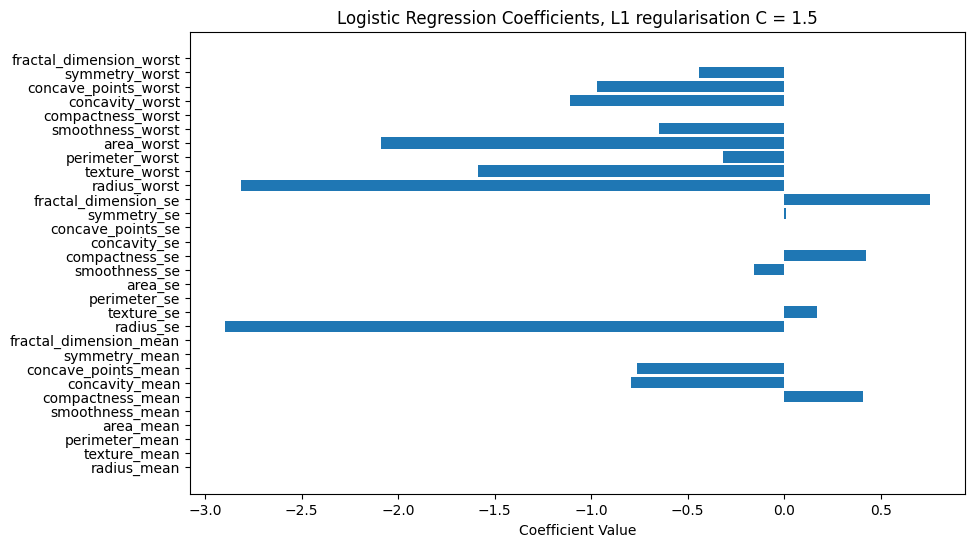

In [ ]:
coef6 = model6.coef_[0]
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coef6)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients, L1 regularisation C = 1.5')
plt.show()

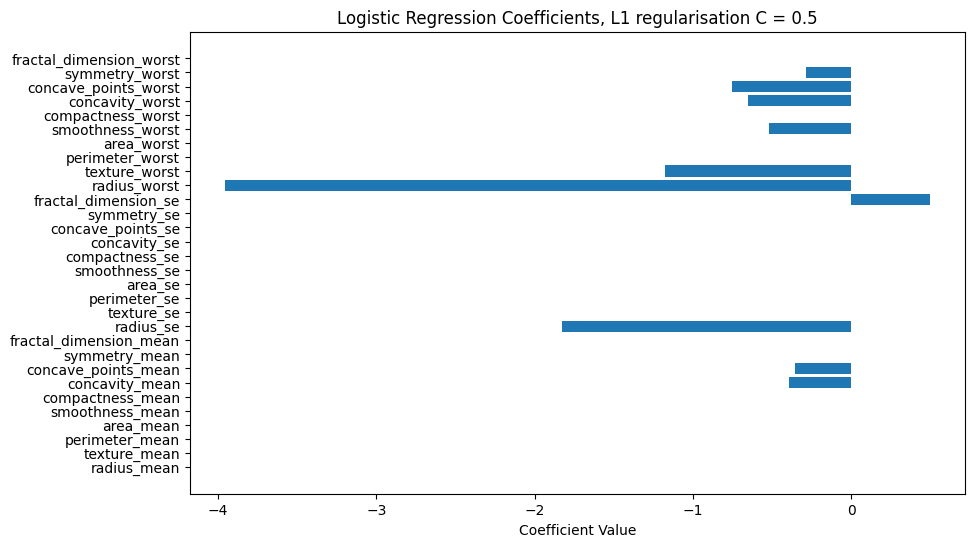

In [ ]:
coef7 = model7.coef_[0]
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coef7)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients, L1 regularisation C = 0.5')
plt.show()

In [ ]:
predictions6 = model6.predict(X_test_scaled)

In [ ]:
predictions7 = model7.predict(X_test_scaled)

In [ ]:
cm6 = confusion_matrix(y_test, predictions6)
print(cm6)

[[34  0]
 [ 4 76]]


In [ ]:
cm7 = confusion_matrix(y_test, predictions7)
print(cm7)

[[34  0]
 [ 4 76]]


In [ ]:
performance(cm6)

Accuracy = 0.9649122807017544
Sensitivity = 0.95
Specificity = 1.0


In [ ]:
performance(cm7)

Accuracy = 0.9649122807017544
Sensitivity = 0.95
Specificity = 1.0


This time we see the same performance for C = 1.5 and worse for C = 0.5. This makes sense as with C = 1.0 we have already driven many of the coefficients to zero and reducing C drives more, and our model becomes too simple. Again we find that using the default C value is good enough. We summarise our results here, noting that models 1,3,4,6,7 did not improve on the models before them so are ignored.

In [ ]:
print("Performance of basic logistic regression:")
performance(cm0)
print("Performance of logistic regression with standard L2 regularisation")
performance(cm2)
print("Performance of logistic regression with standard L1 regularisation")
performance(cm5)

Performance of basic logistic regression:
Accuracy = 0.9473684210526315
Sensitivity = 0.925
Specificity = 1.0
Performance of logistic regression with standard L2 regularisation
Accuracy = 0.9649122807017544
Sensitivity = 0.95
Specificity = 1.0
Performance of logistic regression with standard L1 regularisation
Accuracy = 0.956140350877193
Sensitivity = 0.9375
Specificity = 1.0


To conclude, we saw that a basic logistic regression suffers from overfitting and the multicolinearity in our data. We found that regularisation improves these issues, L1 regularisation was too strong and produced an oversimplified model, whereas L2 produced the best performance

#Decision Trees and Random Forests (Josh)

In this section we explore both decision trees and random forest. We show their lack of sensitivity to the scaling of the features, find hyperparameters and perform tests to compare each of the models to one another.

We also produce a smaller feature set and perform the same calculations on that set. We hope to show only a small proportion of information is lost despite reducing the feature set by over half.

I would like to see if there are any features which show a high correlation to the Diagnonsis target variable. To do so we construct a correlation heatmap and select the diagnonsis column

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
radius_mean,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066,-0.730029
texture_mean,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205,-0.415185
perimeter_mean,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019,-0.742636
area_mean,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738,-0.708984
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316,-0.358560
compactness_mean,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382,-0.596534
concavity_mean,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930,-0.696360
concave_points_mean,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661,-0.776614
symmetry_mean,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413,-0.330499
fractal_dimension_mean,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,0.000111,0.164174,0.039830,-0.090170,0.401964,0.559837,0.446630,0.341198,0.345007,0.688132,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297,0.012838


In [ ]:
cor_target = abs(corr["Diagnosis"])
relevant_features = abs(corr["Diagnosis"]).sort_values(ascending=False).drop('Diagnosis')
print('A sorted list of the correlation between each variable and the target variable')
relevant_features

A sorted list of the correlation between each variable and the target variable


concave_points_worst       0.793566
perimeter_worst            0.782914
concave_points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave_points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
smoothness_se              0.067016
fractal_dimension_mean     0

We select all features with a high correlation to the target variable (>0.5).

In [ ]:
ten_relevant_features = relevant_features[0:15]
names = ten_relevant_features.keys()
print('A sorted list of the variables with >0.5 correlation')
print(ten_relevant_features)

A sorted list of the variables with >0.5 correlation
concave_points_worst    0.793566
perimeter_worst         0.782914
concave_points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
concavity_worst         0.659610
compactness_mean        0.596534
compactness_worst       0.590998
radius_se               0.567134
perimeter_se            0.556141
area_se                 0.548236
Name: Diagnosis, dtype: float64


We would like to further remove variables with high correlation between themselves as we assume they contain similar information.

In [ ]:
X_relevant = X[names]
corr2 = X_relevant.corr()
corr2.style.background_gradient(cmap='coolwarm')

,concave_points_worst,perimeter_worst,concave_points_mean,radius_worst,perimeter_mean,area_worst,radius_mean,area_mean,concavity_mean,concavity_worst,compactness_mean,compactness_worst,radius_se,perimeter_se,area_se
concave_points_worst,1.000000,0.816322,0.910155,0.787424,0.771241,0.747419,0.744214,0.722017,0.861323,0.855434,0.815573,0.801080,0.531062,0.554897,0.538166
perimeter_worst,0.816322,1.000000,0.855923,0.993708,0.970387,0.977578,0.965137,0.959120,0.729565,0.618344,0.590210,0.529408,0.719684,0.721031,0.761213
concave_points_mean,0.910155,0.855923,1.000000,0.830318,0.850977,0.809630,0.822529,0.823269,0.921391,0.752399,0.831135,0.667454,0.698050,0.710650,0.690299
radius_worst,0.787424,0.993708,0.830318,1.000000,0.969476,0.984015,0.969539,0.962746,0.688236,0.573975,0.535315,0.475820,0.715065,0.697201,0.757373
perimeter_mean,0.771241,0.970387,0.850977,0.969476,1.000000,0.941550,0.997855,0.986507,0.716136,0.563879,0.556936,0.455774,0.691765,0.693135,0.744983
area_worst,0.747419,0.977578,0.809630,0.984015,0.941550,1.000000,0.941082,0.959213,0.675987,0.543331,0.509604,0.438296,0.751548,0.730713,0.811408
radius_mean,0.744214,0.965137,0.822529,0.969539,0.997855,0.941082,1.000000,0.987357,0.676764,0.526911,0.506124,0.413463,0.679090,0.674172,0.735864
area_mean,0.722017,0.959120,0.823269,0.962746,0.986507,0.959213,0.987357,1.000000,0.685983,0.512606,0.498502,0.390410,0.732562,0.726628,0.800086
concavity_mean,0.861323,0.729565,0.921391,0.688236,0.716136,0.675987,0.676764,0.685983,1.000000,0.884103,0.883121,0.754968,0.631925,0.660391,0.617427
concavity_worst,0.855434,0.618344,0.752399,0.573975,0.563879,0.543331,0.526911,0.512606,0.884103,1.000000,0.816275,0.892261,0.380585,0.418899,0.385100


From the above heatmap, we decide to replace :



*   radius_worst, perimeter_mean, area_worst, radius_mean, area_mean with radius_worst
*   radius_se, perimeter_se, area_se with radius_se

We do this as they share high correlation with each other and radius_worst and radius_se have the best correlation with the target within these groups.

In [ ]:
def performanceJ(confusion_matrix):
    [[TN, FP] , [FN, TP]] = confusion_matrix.tolist()
    P = TP + FN
    N = TN + FP
    sens = TP / P
    spec = TN / N
    acc = (TP + TN) / (P + N)
    accurancy =  str(acc)
    sensitivity =  str(sens)
    specificity =  str(spec)
    return accurancy, sensitivity,specificity

Above we introduce a performance calculator, we are looking to find the best sensitivity. We include accuracy and specificity for interest.

In [ ]:
X_relevant_dropped = X_relevant.drop(columns=['perimeter_mean','area_worst','radius_mean','area_mean'])
X_trainD, X_testD, y_trainD, y_testD = train_test_split(X_relevant_dropped, y, test_size=0.2, random_state=4)
scaler = StandardScaler()
X_train_scaledD = scaler.fit_transform(X_trainD)
X_test_scaledD = scaler.transform(X_testD)

Below we create 6 models. Basic decision trees and random forests with both scaled and uncscaled data, and a decision tree with optimal parameters.

In [ ]:
def fix_seed():

  # Set seeds for reproducibility
  seed_value = 42

  # 1. Set the seed for Python's built-in random number generator
  random.seed(seed_value)

  # 2. Set the seed for NumPy
  np.random.seed(seed_value)

  # 3. Set the seed for PyTorch
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)  # if using multiple GPUs
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
fix_seed()
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
print(cm)
perf_cm =performanceJ(cm)

[[34  0]
 [10 70]]


Above is the most basic Decision tree we can make. We will use this to set a 'base-line' we hope to improve.

In [ ]:
fix_seed()
model_sc = DecisionTreeClassifier()
model_sc.fit(X_train_scaled, y_train)
predictions_sc = model_sc.predict(X_test_scaled)
cm_sc = confusion_matrix(y_test, predictions_sc)
print(cm_sc)
perf_sc = performanceJ(cm_sc)

[[34  0]
 [10 70]]


A common technique for improving model performance is to scale the data. However this is not the case for decision trees as they are not sensitive to varience in the data. I hope to highlight decision trees lack of sensitivity to scaling data by including both scaled and unscaled data and comparing their predictive ability.

In [ ]:
fix_seed()
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
predictions_rf = model.predict(X_test)
cm_rf = confusion_matrix(y_test, predictions_rf)
print(cm_rf)
perf_rf = performanceJ(cm_rf)

<ipython-input-83-19233215aa06>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train, y_train)


[[34  0]
 [10 70]]


Random forests can be used to increase performance of decision trees by attempting to solve the issue of overfitting.

In [ ]:
fix_seed()
model_rf_scaled = RandomForestClassifier()
model_rf_scaled.fit(X_train_scaled, y_train)
predictions_rf_scaled = model.predict(X_test)
cm_rf_sc = confusion_matrix(y_test, predictions_rf_scaled)
print(cm_rf_sc)
perf_rf_sc = performanceJ(cm_rf_sc)

<ipython-input-84-784168c1489a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf_scaled.fit(X_train_scaled, y_train)


[[34  0]
 [10 70]]


Above we again introduce the scaled data to show a lack of improvement.

We would now like to tune the hyperparameters of the decision tree and random forest model. To do this we introduce the GridSearchCV, which takes an input of the model itself and a dictionary of possible parameters. It then performs cross-validation on every possible combination of parameters given in the dictionary and stores the optimal values.

It should be noted that this method requires the creation of many many models. For example in the random forest parameter search there are $3\times4\times4\times2\times3\times3\times2$ = 1728 models to be made with a 5-fold cross-validation being done. This results in 8640 models being ran, which is obviously extremely computationly expensive. In fact even for our moderately small dataset, whith singular models running almost instantly, the random forest grid search takes almost 22 minuites.

For the decision tree we try all possible measures of fit in sklearn (gini,entropy,log_loss).

Max_features controls how much of the data is seen when performing splits, which can help with overfitting.

ccp_alpha is used to adjust the sensitivity of miniml cost-pruning.

max_depth is used to control the complexity of the model, limiting the depth can help prevent overfitting.

In [ ]:
par_dtc = {'criterion':['gini', 'entropy', 'log_loss'],
           'max_depth':[2,4,6,8],
           'min_samples_split':[2,4,6,8],
          'max_features': ['auto', 'sqrt', 'log2'],
          'ccp_alpha': [0.1, 0.01, 0.001]}
gcv_dtc = GridSearchCV(estimator=model_sc, param_grid=par_dtc, cv=5, verbose=1)
gcv_dtc.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 6, 8]},
             verbose=1)

For the random forest model we again test all criterion along with a selection of ccp_alpha, max_features, max_depth and min_samples_split values.

We also add the min_samples_leaf field to test. This is because with min_samples_leaf=2 we would expect a smoothing effect of the resulting trees, this could cause models which combine together better.

We also would like to see if bootstrapping affects performance, so we add it to the parameter list.


*** Note: the below cell takes over twenty minutes to run, the calculated best parameters are used in the models below. ***

In [ ]:
##Commented out as Grid search takes a long time to run. variables saved below in the model

#par_rtc = {'criterion':['gini', 'entropy', 'log_loss'],
 #          'max_depth':[2,4,6,8],
#           'min_samples_split':[2,4,6,8],
 #          'min_samples_leaf':[1,2],
 #         'max_features': ['auto', 'sqrt', 'log2'],
 ##         'ccp_alpha': [0.1, 0.01, 0.001],
 #          'bootstrap': [True,False]}
#gcv_rtc = GridSearchCV(estimator=model_rf_scaled, param_grid=par_rtc, cv=5, verbose=1)
#gcv_rtc.fit(X_train_scaled, y_train)

We extract the best parameters below and fit an according model to each.

In [ ]:
##Commented out as Grid search takes a long time to run. variables saved below in the model
#randforestparam = gcv_rtc.best_params_
#print(randforestparam)

In [ ]:
##Commented out as Grid search takes a long time to run. variables saved below in the model
#dectreeparam = gcv_dtc.best_params_
#print(dectreeparam)

In [ ]:
fix_seed()
rtc_new = RandomForestClassifier(ccp_alpha= 0.001,criterion= 'log_loss',max_depth= 8,max_features= 'log2',min_samples_split=2,min_samples_leaf=2,bootstrap=True)

In [ ]:
fix_seed()
model_sc_dt = DecisionTreeClassifier(ccp_alpha=0.01,criterion='log_loss',max_depth= 8,max_features= 'auto',min_samples_split= 4)

In [ ]:
fix_seed()
model_sc_dt.fit(X_train_scaled, y_train)
predictions_sc_dt = model_sc_dt.predict(X_test_scaled)
cm_sc_dt = confusion_matrix(y_test, predictions_sc_dt)
print(cm_sc_dt)
perf_sc_dt = performanceJ(cm_sc_dt)

[[33  1]
 [13 67]]


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


In [ ]:
fix_seed()
rtc_new.fit(X_train_scaled, y_train)
pred_rtc = rtc_new.predict(X_test_scaled)
cm_rtc = confusion_matrix(y_test, pred_rtc)
print(cm_rtc)
perf_rtc = performanceJ(cm_rtc)

<ipython-input-92-e0cfdeb86858>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rtc_new.fit(X_train_scaled, y_train)


[[33  1]
 [ 6 74]]


In [ ]:
performancedf = {'Model Type': ['Standard Tree', 'Scaled data Tree','Scaled data Tree best Param','Random Rorest','Random Forest Scaled','RandomForest best param'],
                 'Accurancy': [perf_cm[0],perf_sc[0],perf_sc_dt[0],perf_rf[0],perf_rf_sc[0],perf_rtc[0]],
                 'Sensitivity': [perf_cm[1],perf_sc[1],perf_sc_dt[1],perf_rf[1],perf_rf_sc[1],perf_rtc[1]],
                 'Specificity': [perf_cm[2],perf_sc[2],perf_sc_dt[2],perf_rf[2],perf_rf_sc[2],perf_rtc[2]]}
performancedf = pd.DataFrame(data=performancedf)
performancedf

,Model Type,Accurancy,Sensitivity,Specificity
0,Standard Tree,0.9122807017543859,0.875,1.0
1,Scaled data Tree,0.9122807017543859,0.875,1.0
2,Scaled data Tree best Param,0.8771929824561403,0.8375,0.9705882352941176
3,Random Rorest,0.9122807017543859,0.875,1.0
4,Random Forest Scaled,0.9122807017543859,0.875,1.0
5,RandomForest best param,0.9385964912280702,0.925,0.9705882352941176


As we hoped to show, the scaling of the data had no effect on the predictive capability for either the decision tree or the random forest.

Our hyperparameter search also managed to increase accuracy and sensitivity for the random forest, however this improvement still falls behind the other models.



We would also like to inspect the roc_auc_score. This measures the area underneath an roc curve, with 1 indicating perfect performance and 0.5 suggesting completely random guesses.

In [ ]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, predictions)
print('roc_auc_score for Decision Tree: ', roc_auc_score(y_test, predictions))

false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, predictions_sc)
print('roc_auc_score for Decision Tree with scaled data: ', roc_auc_score(y_test, predictions_sc))

false_positive_rate5, true_positive_rate5, threshold5 = roc_curve(y_test, predictions_sc_dt)
print('roc_auc_score for Decision Tree with parameters: ', roc_auc_score(y_test, predictions_sc_dt))

false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_test, predictions_rf)
print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, predictions_rf))

false_positive_rate6, true_positive_rate6, threshold6 = roc_curve(y_test, predictions_rf_scaled)
print('roc_auc_score for Random Forest with scaled data: ', roc_auc_score(y_test, predictions_rf_scaled))

false_positive_rate4, true_positive_rate4, threshold4 = roc_curve(y_test, pred_rtc)
print('roc_auc_score for Random Forest with parameters: ', roc_auc_score(y_test, pred_rtc))

roc_auc_score for Decision Tree:  0.9375
roc_auc_score for Decision Tree with scaled data:  0.9375
roc_auc_score for Decision Tree with parameters:  0.9040441176470588
roc_auc_score for Random Forest:  0.9375
roc_auc_score for Random Forest with scaled data:  0.9375
roc_auc_score for Random Forest with parameters:  0.9477941176470588


The roc_auc score in highest for the random forest with hyperparameters. This is to be expected as it is the most complex model.

Below we investigate the effect removing variables which were lowly correlated to the response variable and highly correlated to each other.

In [ ]:
fix_seed()
rtc_newD = RandomForestClassifier(ccp_alpha= 0.001,criterion= 'log_loss',max_depth= 8,max_features= 'log2',min_samples_split=2,min_samples_leaf=2,bootstrap=True)
model_sc_dtD = DecisionTreeClassifier(ccp_alpha=0.01,criterion='log_loss',max_depth= 8,max_features= 'auto',min_samples_split= 4)
rtc_newD.fit(X_train_scaledD, y_trainD)
pred_rtcD = rtc_newD.predict(X_test_scaledD)
cm_rtcD = confusion_matrix(y_testD, pred_rtcD)
print(cm_rtcD)
perf_rtcD = performanceJ(cm_rtcD)
model_sc_dtD.fit(X_train_scaledD, y_trainD)
predictions_sc_dtD = model_sc_dtD.predict(X_test_scaledD)
cm_sc_dtD = confusion_matrix(y_testD, predictions_sc_dtD)
print(cm_sc_dtD)
perf_sc_dtD = performanceJ(cm_sc_dtD)
model_rf_scaledD = RandomForestClassifier()
model_rf_scaledD.fit(X_train_scaledD, y_trainD)
predictions_rf_scaledD = model_rf_scaledD.predict(X_testD)
cm_rf_scD = confusion_matrix(y_testD, predictions_rf_scaledD)
print(cm_rf_scD)
perf_rf_scD = performanceJ(cm_rf_scD)
model_rfD = RandomForestClassifier()
model_rfD.fit(X_trainD, y_trainD)
predictions_rfD = model_rfD.predict(X_testD)
cm_rfD = confusion_matrix(y_testD, predictions_rfD)
print(cm_rfD)
perf_rfD = performanceJ(cm_rfD)
model_scD = DecisionTreeClassifier()
model_scD.fit(X_train_scaledD, y_trainD)
predictions_scD = model_scD.predict(X_test_scaledD)
cm_scD = confusion_matrix(y_testD, predictions_scD)
print(cm_scD)
perf_scD = performanceJ(cm_scD)
modelD = DecisionTreeClassifier()
modelD.fit(X_trainD, y_trainD)
predictionsD = modelD.predict(X_testD)
cmD = confusion_matrix(y_testD, predictionsD)
print(cmD)
perf_cmD =performanceJ(cmD)



<ipython-input-96-5dbdd35eebf7>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rtc_newD.fit(X_train_scaledD, y_trainD)


[[33  1]
 [ 8 72]]
[[32  2]
 [ 8 72]]


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
<ipython-input-96-5dbdd35eebf7>:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf_scaledD.fit(X_train_scaledD, y_trainD)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
<ipython-input-96-5dbdd35eebf7>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rfD.fit(X_trainD, y_trainD)


[[34  0]
 [80  0]]
[[33  1]
 [12 68]]
[[34  0]
 [12 68]]
[[33  1]
 [11 69]]


In [ ]:
print('For the reduced data set:')
print('roc_auc_score for Decision Tree: ', roc_auc_score(y_testD, predictionsD))


print('roc_auc_score for Decision Tree with scaled data: ', roc_auc_score(y_testD, predictions_scD))


print('roc_auc_score for Decision Tree with parameters: ', roc_auc_score(y_testD, predictions_sc_dtD))


print('roc_auc_score for Random Forest: ', roc_auc_score(y_testD, predictions_rfD))


print('roc_auc_score for Random Forest with scaled data: ', roc_auc_score(y_testD, predictions_rf_scaledD))

print('roc_auc_score for Random Forest with parameters: ', roc_auc_score(y_testD, pred_rtcD))

For the reduced data set:
roc_auc_score for Decision Tree:  0.9165441176470589
roc_auc_score for Decision Tree with scaled data:  0.925
roc_auc_score for Decision Tree with parameters:  0.9205882352941176
roc_auc_score for Random Forest:  0.9102941176470588
roc_auc_score for Random Forest with scaled data:  0.5
roc_auc_score for Random Forest with parameters:  0.9352941176470587


The ROC scores are very similar, but slightly below to the models fit on the whole dataset. the scaled random forest has failed as it is competely random (=0.5).

I would like to explore the performance of all the models with both the whole feature set and the reduced feature set.

In [ ]:
performancedfD = {'Model Type with Dropped Features': ['Standard Tree', 'Scaled data Tree','Scaled data Tree best Param','Random Rorest','Random Forest Scaled','RandomForest best param'],
                 'Accurancy': [perf_cmD[0],perf_scD[0],perf_sc_dtD[0],perf_rfD[0],perf_rf_scD[0],perf_rtcD[0]],
                 'Sensitivity': [perf_cmD[1],perf_scD[1],perf_sc_dtD[1],perf_rfD[1],perf_rf_scD[1],perf_rtcD[1]],
                 'Specificity': [perf_cmD[2],perf_scD[2],perf_sc_dtD[2],perf_rfD[2],perf_rf_scD[2],perf_rtcD[2]]}
performancedfD = pd.DataFrame(data=performancedfD)
performancedfD

,Model Type with Dropped Features,Accurancy,Sensitivity,Specificity
0,Standard Tree,0.8947368421052632,0.8625,0.9705882352941176
1,Scaled data Tree,0.8947368421052632,0.85,1.0
2,Scaled data Tree best Param,0.9122807017543859,0.9,0.9411764705882353
3,Random Rorest,0.8859649122807017,0.85,0.9705882352941176
4,Random Forest Scaled,0.2982456140350877,0.0,1.0
5,RandomForest best param,0.9210526315789473,0.9,0.9705882352941176


In [ ]:
performancedf = {'Model Type': ['Standard Tree', 'Scaled data Tree','Scaled data Tree best Param','Random Rorest','Random Forest Scaled','RandomForest best param'],
                 'Accurancy': [perf_cm[0],perf_sc[0],perf_sc_dt[0],perf_rf[0],perf_rf_sc[0],perf_rtc[0]],
                 'Sensitivity': [perf_cm[1],perf_sc[1],perf_sc_dt[1],perf_rf[1],perf_rf_sc[1],perf_rtc[1]],
                 'Specificity': [perf_cm[2],perf_sc[2],perf_sc_dt[2],perf_rf[2],perf_rf_sc[2],perf_rtc[2]]}
performancedf = pd.DataFrame(data=performancedf)
performancedf

,Model Type,Accurancy,Sensitivity,Specificity
0,Standard Tree,0.9122807017543859,0.875,1.0
1,Scaled data Tree,0.9122807017543859,0.875,1.0
2,Scaled data Tree best Param,0.8771929824561403,0.8375,0.9705882352941176
3,Random Rorest,0.9122807017543859,0.875,1.0
4,Random Forest Scaled,0.9122807017543859,0.875,1.0
5,RandomForest best param,0.9385964912280702,0.925,0.9705882352941176


It seems the data which had dropped features seems to perform on average slightly worse for random forests. This suggests to me that the data was overfitting very slightly and most data held at least a little value/ information regarding the target variable.

Despite the dropped variables being highly correlated with each other and lowly correlated with the traget variable, there was still some information to be gained by adding them in.

However, the model still performs with a sensitivity only a few percent lower for all models. This is remarkable considering over half of the features were dropped. This does sugest the highly correlated variables shared alot of the information.

The Random forest with hyperparameters performs the best, our parameter search managed to increase sensitivity by 10\%, highlighting the importance of hyperparameters for decision trees as they are very sensitive.

I am unsure as to the reason the scaled random forest with dropped out data performed to poorly. Also the fact that the removal of data in the decision tree with hyperparameters suggests that the tree was overfitting to the data.

# Neural Networks (Ethan)

Here we will explore simple feed-forward neural networks and how well they can classify the dataset.

Firstly, we must define a fix_seed function that will set seeds across multiple Python packages used to ensure reproducibility. We will call this appropriately in all of our experiments.

First we will convert the data to PyTorch tensors so that we can train neural networks on them in PyTorch.

In [ ]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

Next we define a simple feed-forward neural network model, that takes in a list of hidden units and the length of the list is the number of hidden layers. The input layers are 30 as the data is 30-dimensional and the output layer is 2 as it is a binary classifier.

In [ ]:
# Define your neural network model
class SimpleNN(nn.Module):
    def __init__(self, hidden_sizes):
        super(SimpleNN, self).__init__()
        self.layers = []
        prev_layer_size = 30
        for h in hidden_sizes:
            self.layers.append(nn.Linear(prev_layer_size, h))
            self.layers.append(nn.ReLU())
            prev_layer_size = h
        self.layers.append(nn.Linear(prev_layer_size, 1))
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return torch.sigmoid(self.model(x))

A problem in training neural networks in knowing when to stop training, or equivalently for how many epochs we should train our network. Typically, we do this by using some validation set and stopping when the performance on this set is maximised.

Now, we could use the predefined held-out test set from the train-test split, but technically this would be using knowledge of the test data to improve performance on that same test data, which is clearly biased.
Instead, we take a chunk out of our training set that we will not train the neural network on, and instead use for validating our model's performance (in particular, by working out the sensitivity on this validation data).

However, how do we decide which chunk of data to hold for validation? Taking any chunk out means that we do not use the whole training set for training our model to be used on the test set. Thus, we will employ cross-validation here. We will train 5 folds of our model, holding a separate chunk (one fifth) of the data each time as validation data, and average our results across the 5 folds. This is a much more robust way of training and experimenting with different neural network set-ups. This is what the next function is written to do.

In [ ]:
def kf_train_nn(hidden_sizes, plot=False, return_models=False):
  fix_seed()
  kf = KFold(n_splits=5, shuffle=True, random_state=42)

  fold=1
  best_model_sds = []
  test_sensitivities = []
  for train_index, val_index in kf.split(X_train_tensor):

    X_train_cv, X_val_cv = X_train_tensor[train_index], X_train_tensor[val_index]
    y_train_cv, y_val_cv = y_train_tensor[train_index], y_train_tensor[val_index]

    model = SimpleNN(hidden_sizes)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_sensitivity = 0
    best_epoch = 0
    best_model_sd = model.state_dict()

    tloss = []
    vloss = []

    for epoch in range(500):
      model.train()
      optimizer.zero_grad()

      output = model(X_train_cv)
      loss = criterion(output, y_train_cv.view(-1,1))
      tloss.append(loss.detach().numpy())

      loss.backward()
      optimizer.step()

      with torch.no_grad():
        val_output = model(X_val_cv)
        val_loss = criterion(val_output, y_val_cv.view(-1, 1))
        vloss.append(val_loss.detach().numpy())
        predicted_labels = (val_output > 0.5).float()
        # val_acc = (predicted_labels == y_val_cv.view(-1, 1)).float().mean()
        # if val_acc >= best_sensitivity:
        #   best_sensitivity = val_acc
        #   best_epoch = epoch
        sensitivity = calculate_sensitivity(y_val_cv, predicted_labels)
        if sensitivity >= best_sensitivity:
          best_sensitivity = sensitivity
          best_epoch = epoch
          best_model_sd = model.state_dict()

    if plot:
      plt.figure()
      plt.plot(tloss, label='training')
      plt.plot(vloss, label='validation')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()

    print(f'Fold {fold}.')
    print(f'Best model was at {best_epoch} epochs and achieved validation sensitivity of {best_sensitivity}.')
    best_model = SimpleNN(hidden_sizes)
    best_model_sds.append(best_model_sd)
    best_model.load_state_dict(best_model_sd)
    best_model.eval()

    # Compute performance on held-out test set
    test_output = best_model(X_test_tensor)
    test_predictions = (test_output > 0.5).float()
    test_sensitivity = calculate_sensitivity(y_test_tensor, test_predictions)
    test_sensitivities.append(test_sensitivity)
    print(f'It achieved test sensitivity of {test_sensitivity}.')
    print('\n')
    fold += 1

  print(f'Mean test sensitivity = {np.mean(test_sensitivities):.4f}.')

  if return_models:
    return best_model_sds

To start, we consider a very simple neural network with one hidden layer of 4 units. We also plot the training and validation loss of each fold to check what is going on and that it makes sense.

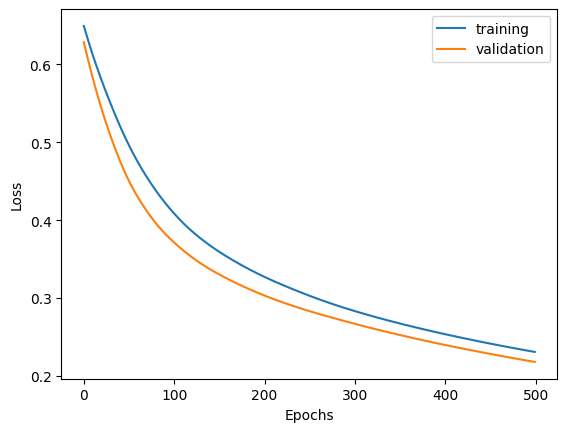

Fold 1.
Best model was at 499 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.95.




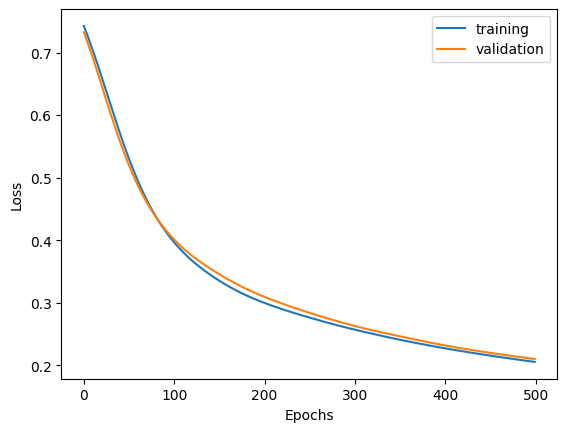

Fold 2.
Best model was at 499 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.95.




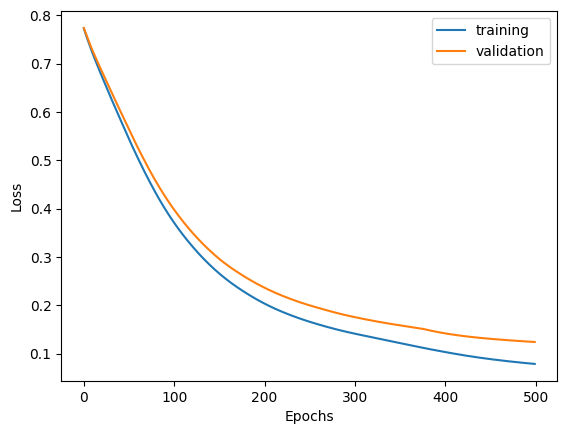

Fold 3.
Best model was at 499 epochs and achieved validation sensitivity of 0.9642857142857143.
It achieved test sensitivity of 0.9625.




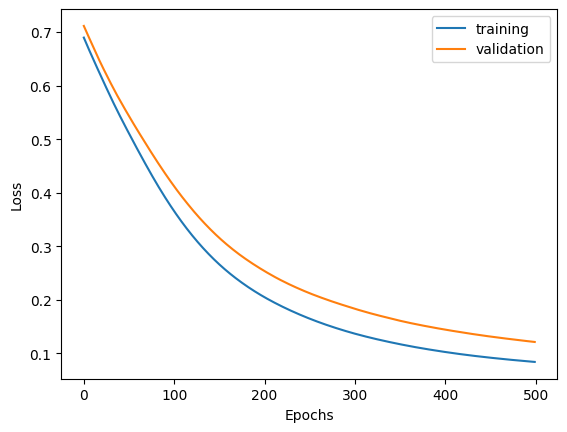

Fold 4.
Best model was at 46 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.9375.




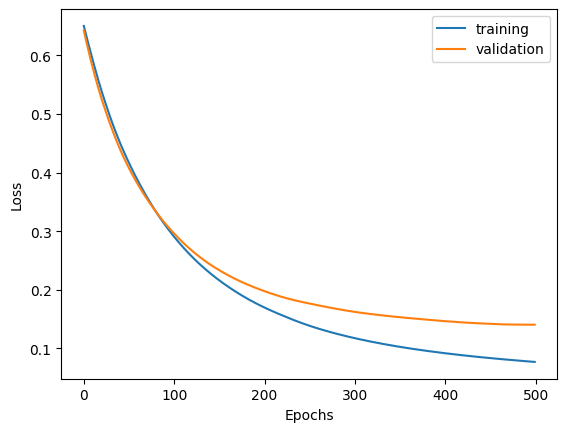

Fold 5.
Best model was at 276 epochs and achieved validation sensitivity of 0.9811320754716981.
It achieved test sensitivity of 0.975.


Mean test sensitivity = 0.9550.


In [ ]:
kf_train_nn([4], plot=True)

Firstly, we note that loss continues to decrease on both training and validation data across all folds. This is reassuring, as it means the validation loss does not start going up during 500 epochs, meaning the models are not likely to overfit that much if training for 500 epochs.

We do however notice some overfitting. For example, in fold 4 the best model (for sensitivity) according to the validation data occured after 46 epochs, but this model had the worst test sensitivity. This specific training-validation split was 'unlucky' in this sense, in that the validation data fooled the network into thinking it was working perfectly after 46 epochs, whereas in actuality it may have needed to continue training to perform better on the held-out test data. Overall, this is more evidence to support the use of cross-validation when training models, as it makes them more robust and minimises falling into these 'unlucky' scenarios.



Now we will try other models with one hidden layer but with more hidden units in this layer.

In [ ]:
kf_train_nn([8])

Fold 1.
Best model was at 499 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.9375.


Fold 2.
Best model was at 183 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.9625.


Fold 3.
Best model was at 499 epochs and achieved validation sensitivity of 0.9642857142857143.
It achieved test sensitivity of 0.9375.


Fold 4.
Best model was at 499 epochs and achieved validation sensitivity of 0.9814814814814815.
It achieved test sensitivity of 0.9375.


Fold 5.
Best model was at 499 epochs and achieved validation sensitivity of 0.9811320754716981.
It achieved test sensitivity of 0.9625.


Mean test sensitivity = 0.9475.


In [ ]:
kf_train_nn([16])

Fold 1.
Best model was at 499 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.95.


Fold 2.
Best model was at 239 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.9625.


Fold 3.
Best model was at 164 epochs and achieved validation sensitivity of 0.9821428571428571.
It achieved test sensitivity of 0.9625.


Fold 4.
Best model was at 499 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.9625.


Fold 5.
Best model was at 499 epochs and achieved validation sensitivity of 0.9811320754716981.
It achieved test sensitivity of 0.975.


Mean test sensitivity = 0.9625.


In [ ]:
kf_train_nn([32])

Fold 1.
Best model was at 499 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.95.


Fold 2.
Best model was at 298 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.95.


Fold 3.
Best model was at 15 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.95.


Fold 4.
Best model was at 363 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.975.


Fold 5.
Best model was at 53 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.9875.


Mean test sensitivity = 0.9625.


In [ ]:
kf_train_nn([64])

Fold 1.
Best model was at 499 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.95.


Fold 2.
Best model was at 126 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.95.


Fold 3.
Best model was at 75 epochs and achieved validation sensitivity of 0.9821428571428571.
It achieved test sensitivity of 0.95.


Fold 4.
Best model was at 231 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.9625.


Fold 5.
Best model was at 499 epochs and achieved validation sensitivity of 0.9622641509433962.
It achieved test sensitivity of 0.975.


Mean test sensitivity = 0.9575.


We see that both 16 and 32 hidden units resulted in the highest test sensitivity of 0.9625. We favour smaller/simpler models as they are less likely to overfit, so let us consider more models with the first hidden layer of 16 units.

We try a few options like this but with more than one hidden layer.

In [ ]:
kf_train_nn([16, 8])

Fold 1.
Best model was at 499 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.95.


Fold 2.
Best model was at 198 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.95.


Fold 3.
Best model was at 96 epochs and achieved validation sensitivity of 0.9821428571428571.
It achieved test sensitivity of 0.9625.


Fold 4.
Best model was at 286 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.975.


Fold 5.
Best model was at 201 epochs and achieved validation sensitivity of 0.9811320754716981.
It achieved test sensitivity of 0.9875.


Mean test sensitivity = 0.9650.


In [ ]:
kf_train_nn([16, 8, 4])

Fold 1.
Best model was at 499 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.9625.


Fold 2.
Best model was at 499 epochs and achieved validation sensitivity of 0.9811320754716981.
It achieved test sensitivity of 0.9125.


Fold 3.
Best model was at 164 epochs and achieved validation sensitivity of 0.9821428571428571.
It achieved test sensitivity of 0.9375.


Fold 4.
Best model was at 88 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.9625.


Fold 5.
Best model was at 87 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.975.


Mean test sensitivity = 0.9500.


In [ ]:
kf_train_nn([16, 16, 16])

Fold 1.
Best model was at 499 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.95.


Fold 2.
Best model was at 185 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.95.


Fold 3.
Best model was at 101 epochs and achieved validation sensitivity of 0.9821428571428571.
It achieved test sensitivity of 0.925.


Fold 4.
Best model was at 331 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.975.


Fold 5.
Best model was at 74 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.95.


Mean test sensitivity = 0.9500.


The test sensitivities for these models are no better; in fact for the later two (the more complex models) the test sensitivities are even lower. This suggests that complicated neural networks are not needed here; they are overkill and actually cause the neural network to overfit to their specific training data.

Neural networks are usually designed for much more complicated kinds of data (like images or genetics). For classifcation of tabular data like this breast cancer dataset, there is not much need for bigger architectures or extra features to push performance and in fact, the performance is already very high.

We have seen that simpler neural networks are usually performing better on this dataset, so as a final test let us train a neural network with no hidden layers at all (which we do by passing an empty list to its construction).

In [ ]:
model_sds = kf_train_nn([], return_models=True)

Fold 1.
Best model was at 499 epochs and achieved validation sensitivity of 1.0.
It achieved test sensitivity of 0.9875.


Fold 2.
Best model was at 499 epochs and achieved validation sensitivity of 0.9811320754716981.
It achieved test sensitivity of 0.975.


Fold 3.
Best model was at 499 epochs and achieved validation sensitivity of 0.9642857142857143.
It achieved test sensitivity of 0.9625.


Fold 4.
Best model was at 499 epochs and achieved validation sensitivity of 0.9814814814814815.
It achieved test sensitivity of 0.975.


Fold 5.
Best model was at 40 epochs and achieved validation sensitivity of 0.9811320754716981.
It achieved test sensitivity of 0.975.


Mean test sensitivity = 0.9750.


And we achieve the highest test sensitivity yet! Thus further corroborates our observations and suggests that there really is no need for complicated neural network architectures or other features here.

Finally, let us take the 5 best models from the cross-validated training and combine them into one ensembled model (which we do by taking the majority prediction vote) and checking its performance on the held-out test data.

In [ ]:
preds=[]
for model_sd in model_sds:
  model = SimpleNN([])
  model.load_state_dict(model_sd)
  model.eval()
  pred = model(X_test_tensor)
  preds.append(pred)

stacked_preds = torch.stack(preds)
mean_preds = torch.mean(stacked_preds, dim=0)
ensemble_preds =(mean_preds > 0.5).float()
test_sensitivity = calculate_sensitivity(y_test_tensor, ensemble_preds)
print(test_sensitivity)

0.975


The test sensitivity for this ensembled model is equal to the mean test sensitivity of the 5 models from the cross-validation, which is perhaps expected.

# Conclusion

We present the best model options alongside their sensitivity values on the test data, from each of our experiments of different binary classifiers.

| Model | Best option |Test sensitivity |
|-------|-------------|-----------------|
|Logistic regression | L2 regularisation with C=1|0.95|
|SVM| linearSVC|  0.9875 |
|Random forest | Optimised parameters | 0.925 |
|Neural network| Simple two-layer (no hidden layers) | 0.975|

Firstly, we note that all models achieved high performance on the sensitivity metric on the held-out test data, with SVMs narrowly beating the other models.

We briefly summarise the results of our experiments on each classifier.

**Logistic regression**. We found that regularisation improves model performance, probably due to how it makes models simpler which leads to less overfitting.

**SVM**. We found that linearSVC performed the best, again due to it being one of the most simple forms of the model. We also found that on this dataset, SVMs worked best for improving the metrics of ROC and sensitivity.

**Decision trees and random forests**. We found that these models are invariant to scaling. Also, although these models perform well out-of-the-box, they benefit from thorough hyperparameter optimisation due to the high number of parameters that can be tuned for such models.

**Neural networks**. Neural networks are likely overly complicated for such a simple binary classification from tabular data. We found once again that the simplest model with only 2 layers (input and output) achieved the best sensitivity metric on the test data.

Across the board, it was a general trend that simpler models (either through fewer parameters, reduction to linear order or imposing regularisations) performed better, likely because it prevented overfitting to the training data.

Ultimately, this was a great dataset to investigate for binary classification, as demonstrated by all of our models achieving high performance. This was to be expected, due to our analysis of the data itself - there is not too much imbalance between the malignant and benign classes, and indeed many of the features are strongly correlated enough to the diagnosis.